In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
from scipy import interpolate
from sklearn.decomposition import PCA
import sklearn.model_selection as model_selection

from sklearn.preprocessing import StandardScaler
from numpy import corrcoef, cov
from scipy import stats
import scipy.cluster.hierarchy as sch
from scipy.signal import find_peaks
from scipy import stats
from sklearn.pipeline import Pipeline


from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Reading Data 


In [4]:
file = pd.read_csv('20210526_Extracted Data_background subtracted.csv')

keys = file.keys()
dataset_orig = {}

for index in range(0,90,2):
    #print(keys[index])
    col1 = file[keys[index]]
    col2 = file[keys[index+1]]

    list_mz = []
    for i in col1[1:]:
        list_mz.append(float(i))

    list_int = []
    for i in col2[1:]:
        list_int.append(float(i))
    
    mz = np.array(list_mz)
    intensity = np.array(list_int)
    
    ind = np.where(np.isnan(mz))[0]
    if(len(ind) > 0):
        mz = mz[0:ind[0]]
        intensity = intensity[0:ind[0]]
        
    normalized = (intensity - np.mean(intensity))/(np.max(intensity) - np.min(intensity))
    data = {'mz': mz, 'intensity': intensity, 'normalized': normalized}
    dataset_orig[keys[index]] = data

    dataset_orig.keys()

In [5]:
b_samples = {
              'LAC' : 'staphylococcus aureus',
              'UAMS' : 'staphylococcus aureus',
              'NRS101': 'staphylococcus epidermis',
              'CDC33' : 'acinetobacter baumamii',
              'CDC4' : 'klebsiella pneumoniae',
              'AH71' : 'pseudomonas aeruginosa',
              'EU55' : 'enterobacter aerogenes',
              'EU44' : 'enterococcus faccium' ,
              'CDC346' : 'escherichia coli ',
              'CDC29' : 'protesu mirabilis',
              'TSA' : 'Tryptic Soy Agar'
}

f_samples = {
              'EU50' : 'candida albicans',
              'CDC314' : 'candida glabrata',
              'CDC336' : 'malassazia fuf',
              'SBD' : 'Sadbourand Agar'
}

b = []
for b_ in b_samples:
    #print(b_)
    b.append(b_)

f = []
for f_ in f_samples:
    #print(f_)
    f.append(f_)

### Linear Interpolation

In [9]:
#print(x)
#print(len(x))

for k in f_samples:
    for i in range(1,4):
        
        if(k != 'SBD'):

            key = k + '_' + str(i)
            xreal = np.copy(dataset_orig[key]['mz'])
            yreal = np.copy(dataset_orig[key]['normalized'])
            f = interpolate.interp1d(xreal, yreal, fill_value = 'extrapolate')

            xnew = np.copy(dataset_orig['SBD_' + str(i)]['mz'])
            
            ynew = f(xnew)   # use interpolation function returned by `interp1d`
            #print('SBD', len(xnew), len(ynew))
            dataset_orig[key]['mz_interp'] = xnew
            dataset_orig[key]['intensity_interp'] = ynew
            #print(ynew)
            
        else:
            dataset_orig[key]['mz_interp'] = dataset_orig[key]['mz'] 
            dataset_orig[key]['intensity_interp'] = dataset_orig[key]['intensity']
        

for k in b_samples:
    for i in range(1,4):
        
        if(k != 'TSA'):
            key = k + '_' + str(i)
            xreal = np.copy(dataset_orig[key]['mz'])
            yreal = np.copy(dataset_orig[key]['normalized'])
            f = interpolate.interp1d(xreal, yreal, fill_value = 'extrapolate')

            xnew = np.copy(dataset_orig['TSA_' + str(i)]['mz'])
            ynew = f(xnew)   # use interpolation function returned by `interp1d`
            #print('TSA', len(xnew), len(ynew))
            dataset_orig[key]['mz_interp'] = xnew
            dataset_orig[key]['intensity_interp'] = ynew
            #print(ynew)
        else:
            dataset_orig[key]['mz_interp'] = dataset_orig[key]['mz'] 
            dataset_orig[key]['intensity_interp'] = dataset_orig[key]['intensity']
        

### Define Plot Functions

In [10]:
def plot_ms(dataset, key, r = False):
    
    data = dataset[key]
    mz = np.array(data['mz'])
    intensity = np.array(data['normalized'])
    
    if(r):
        r1 = r[0]
        r2 = r[1]
    else:
        r1 = 50
        r2 = 700
    
    index = np.where(np.logical_and(mz < r2, mz > r1))[0]
    i1 = index[0]
    i2 = index[-1]
    print(key)
    print(len(mz[i1:i2]))
    
    plt.plot(mz[i1:i2], intensity[i1:i2])
    plt.show()

def plot_three(dataset, key, val = 'intensity', x = 'mz', blank = ['TSA'], r = False):
    
    data1 = dataset[key + '_1']
    mz1 = np.array(data1[x])
    intensity1 = np.array(data1[val])
    
    data2 = dataset[key + '_2']
    mz2 = np.array(data2[x])
    intensity2 = np.array(data2[val])
    
    data3 = dataset[key + '_3']
    mz3 = np.array(data3[x])
    intensity3 = np.array(data3[val])
    
    if(r):
        r1 = r[0]
        r2 = r[1]
    else:
        r1 = 50
        r2 = 700
    

    
    if(key not in blank):
        fig, a = plt.subplots(1,3, figsize = (15,5))
        index = np.where(np.logical_and(mz1 < r2, mz1 > r1))[0]
        i1 = index[0]
        i2 = index[-1]
        a[0].plot(mz1[i1:i2], intensity1[i1:i2])
        a[0].set_title(key + '_1')
        index = np.where(np.logical_and(mz2 < r2, mz2 > r1))[0]
        i1 = index[0]
        i2 = index[-1]
        a[1].plot(mz2[i1:i2], intensity2[i1:i2] )
        a[1].set_title(key + '_2')
        index = np.where(np.logical_and(mz3 < r2, mz3 > r1))[0]
        i1 = index[0]
        i2 = index[-1]
        a[2].plot(mz3[i1:i2], intensity3[i1:i2] )
        a[2].set_title(key + '_3')
        fig.show()

## Blank Subtraction

In [11]:
for keys in b_samples:
    if(keys != 'TSA'):
        for i in range(1,4):
            blank = 'TSA_' + str(i)
            key = keys + '_' + str(i)
            dataset_orig[key]['blank_corrected'] = dataset_orig[key]['intensity_interp'] -  dataset_orig[blank]['normalized']
            dataset_orig[key]['blank_corrected'][dataset_orig[key]['blank_corrected'] < 0] = 0

for keys in f_samples:
    if(keys != 'SBD'):
        for i in range(1,4):
            blank = 'SBD_' + str(i)
            key = keys + '_' + str(i)
            dataset_orig[key]['blank_corrected'] = dataset_orig[key]['intensity_interp'] -  dataset_orig[blank]['normalized']
            dataset_orig[key]['blank_corrected'][dataset_orig[key]['blank_corrected'] < 0] = 0

ValueError: operands could not be broadcast together with shapes (32064,) (20774,) 

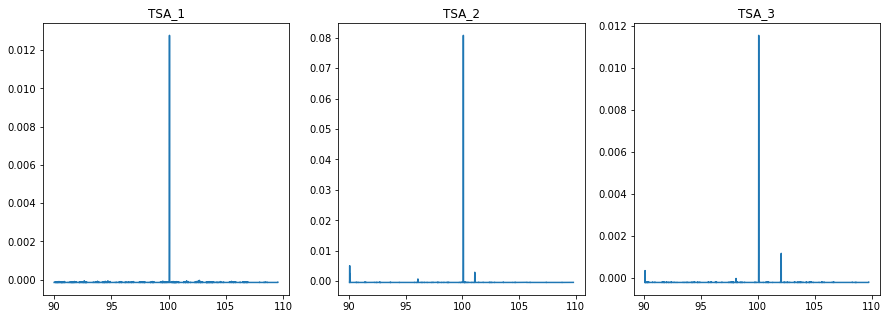

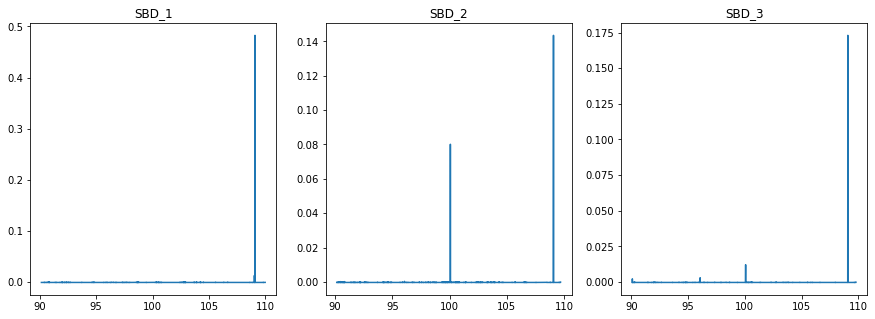

In [76]:
plot_three(dataset_orig, 'TSA', val =  'normalized', x = 'mz', blank = [], r = [90,110])
plot_three(dataset_orig, 'SBD', val =  'normalized', x = 'mz', blank = [], r = [90,110])

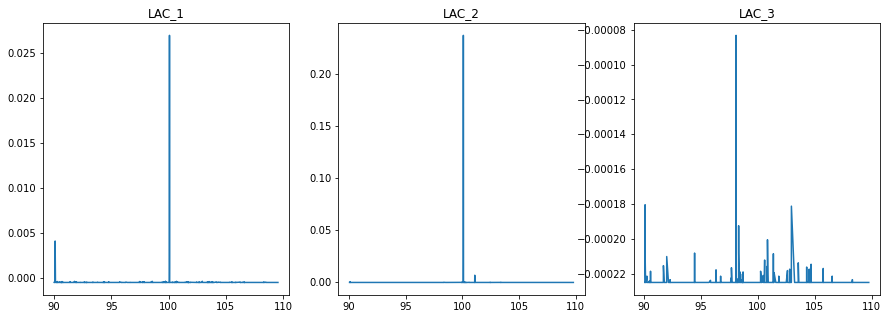

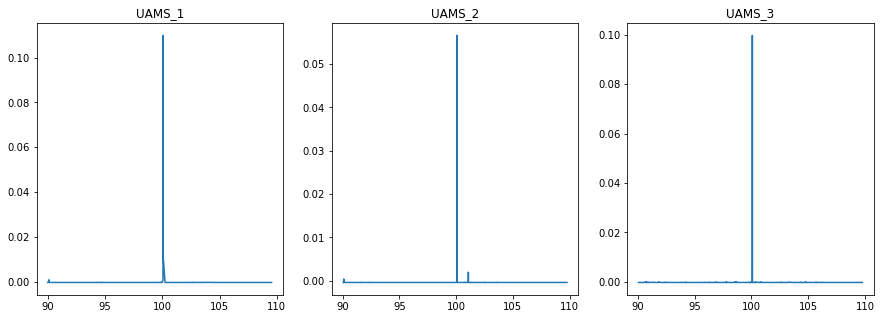

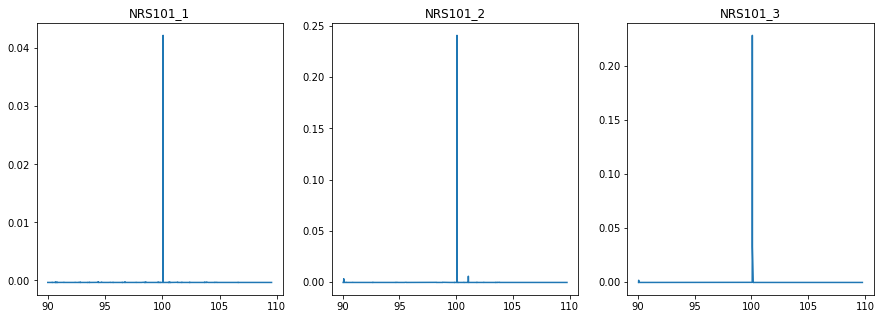

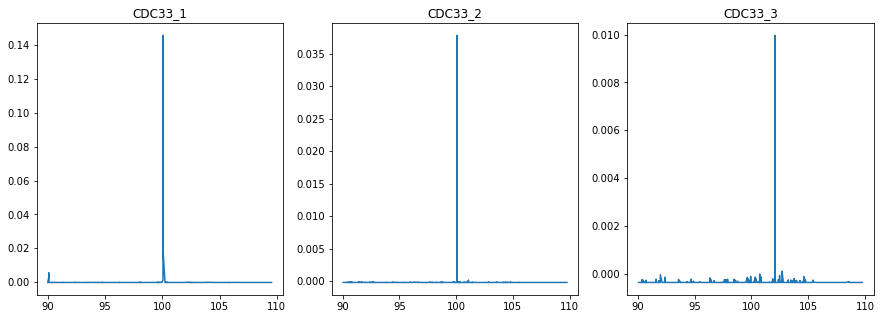

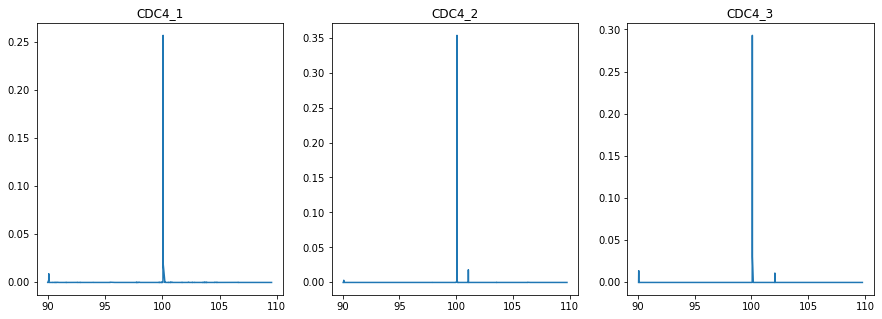

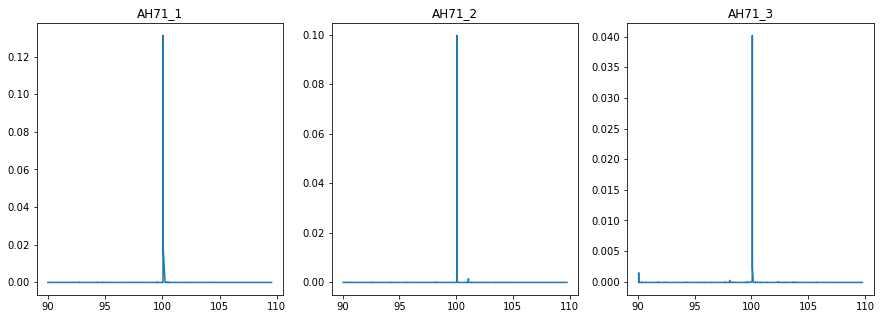

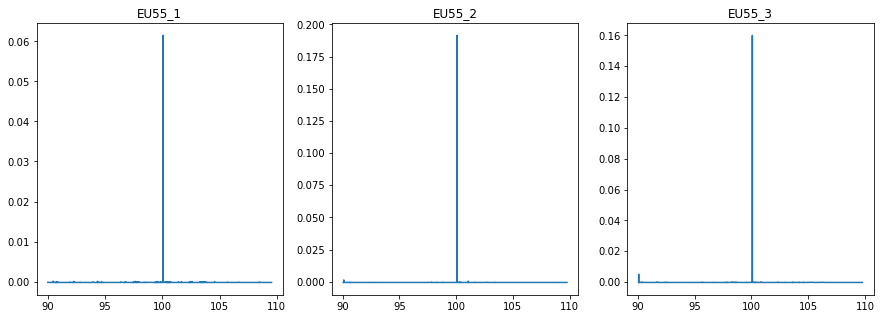

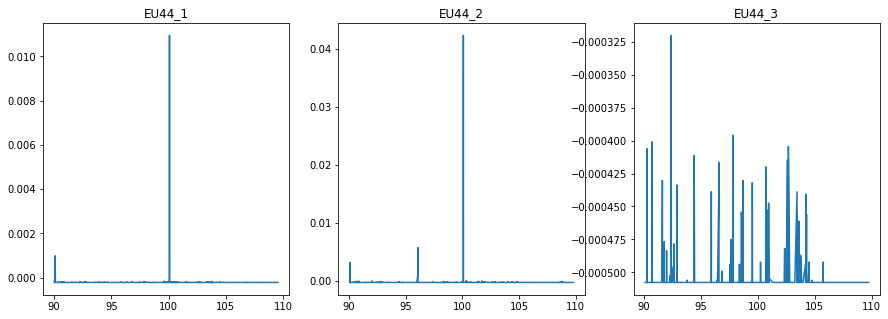

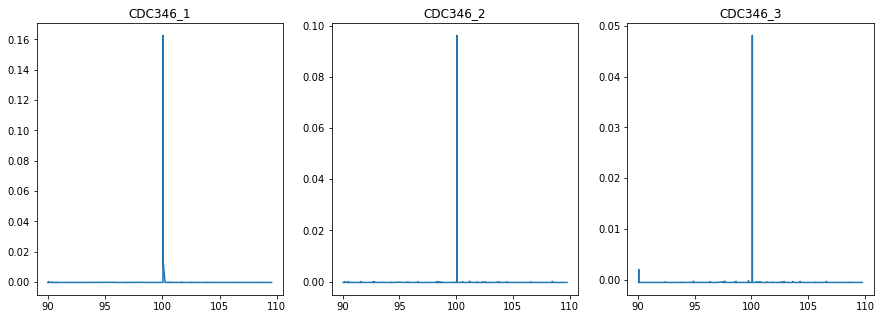

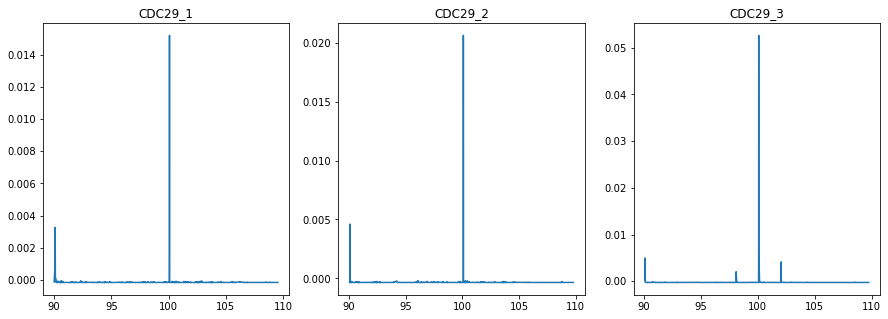

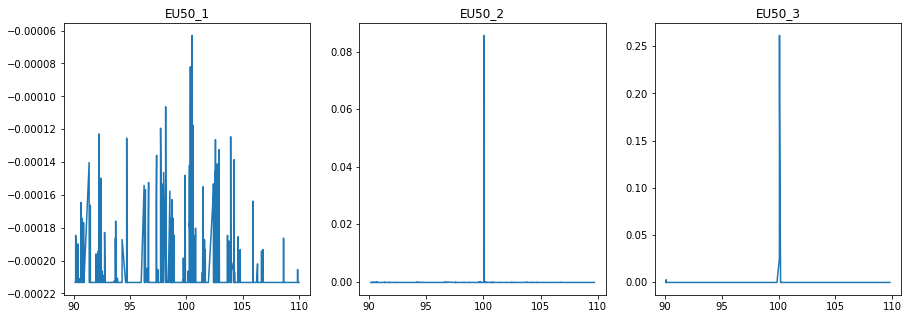

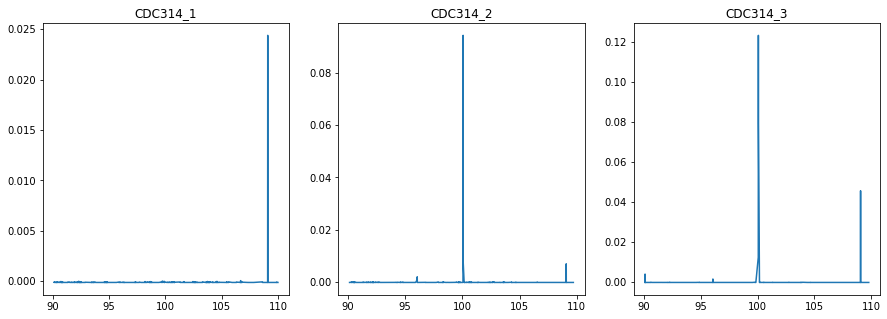

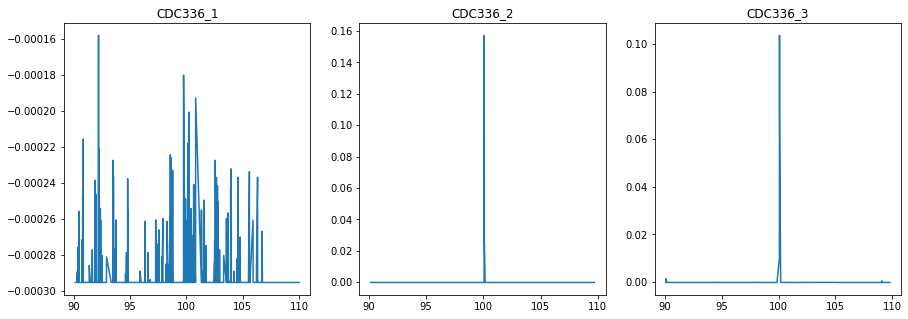

In [78]:
for key in b_samples:
    if(key not in ['TSA']):
        plot_three(dataset_orig, key, val =  'intensity_interp', x = 'mz_interp', blank = ['TSA'], r = [90,110])

for  key in f_samples:
    
    if(key not in ['SBD']):
        plot_three(dataset_orig, key, val =  'intensity_interp', x = 'mz_interp', blank = ['SBD'], r = [90,110])

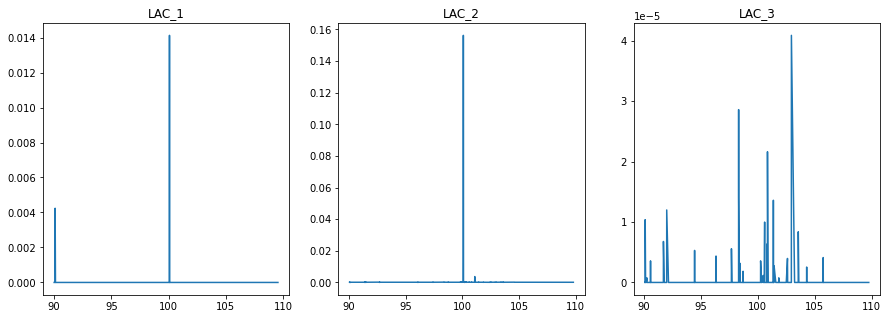

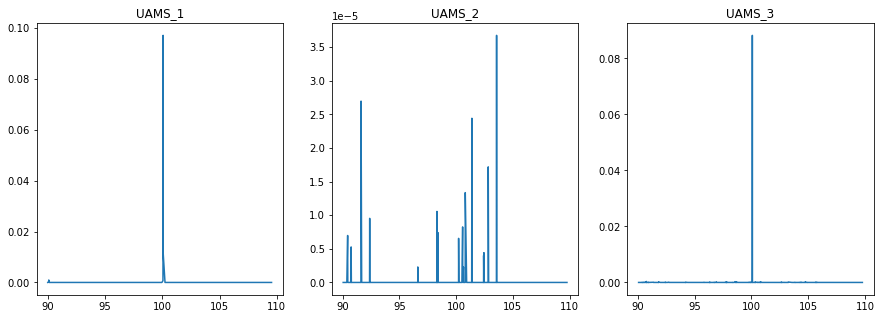

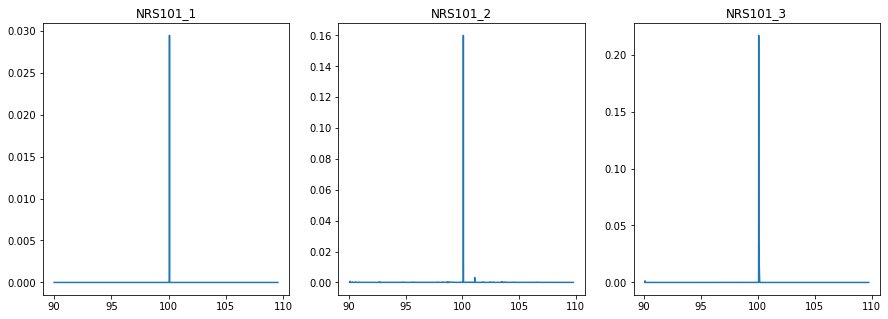

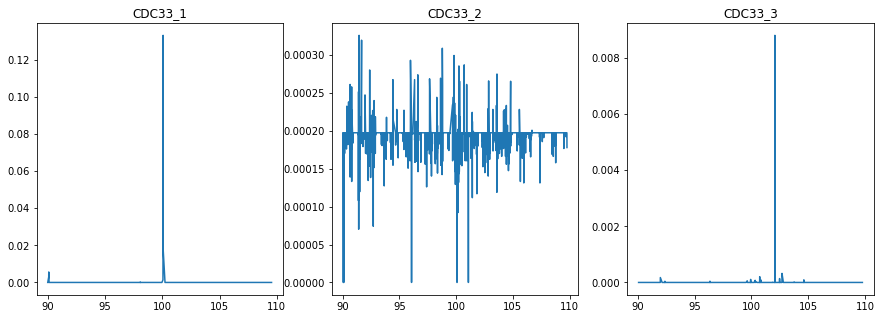

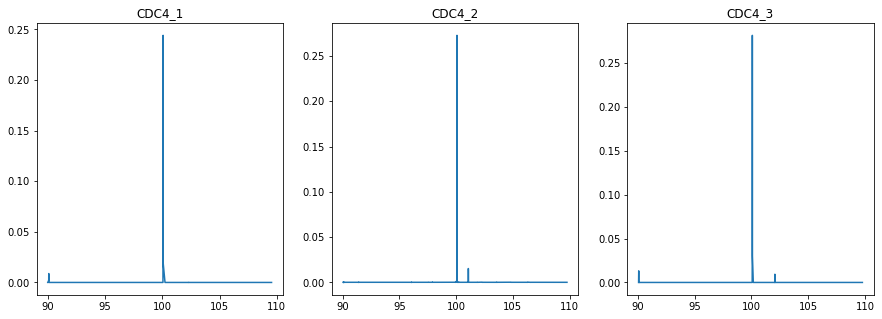

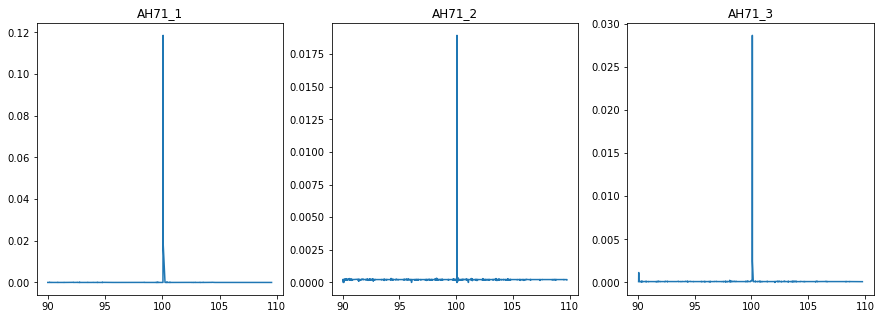

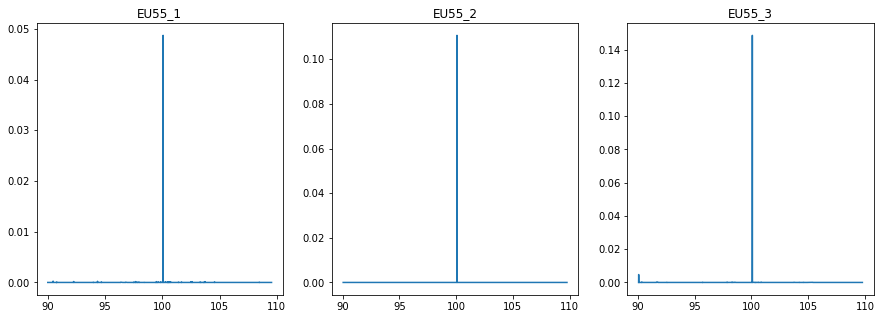

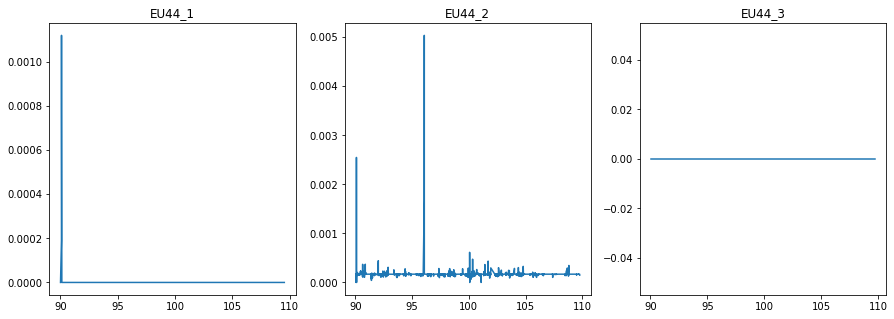

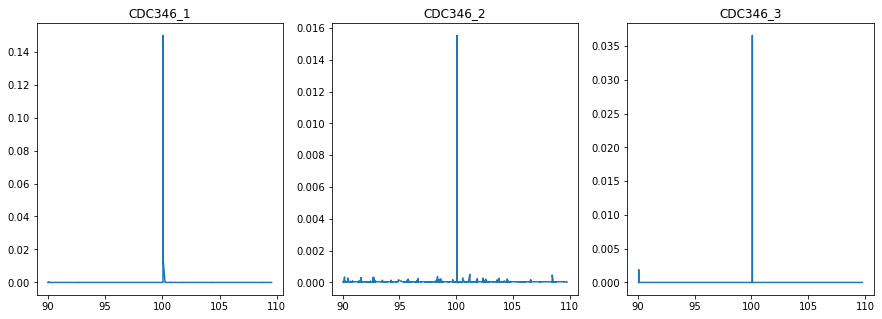

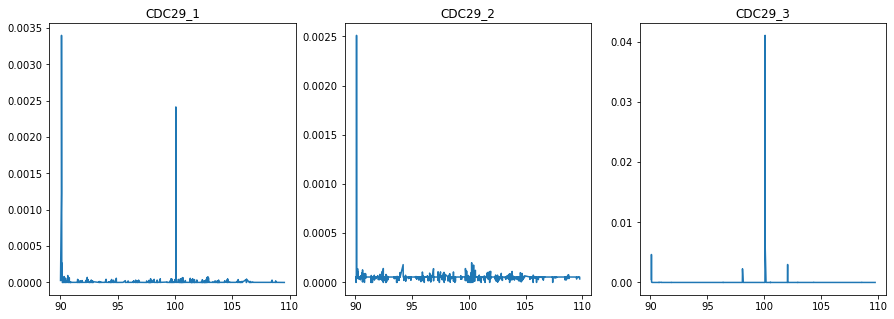

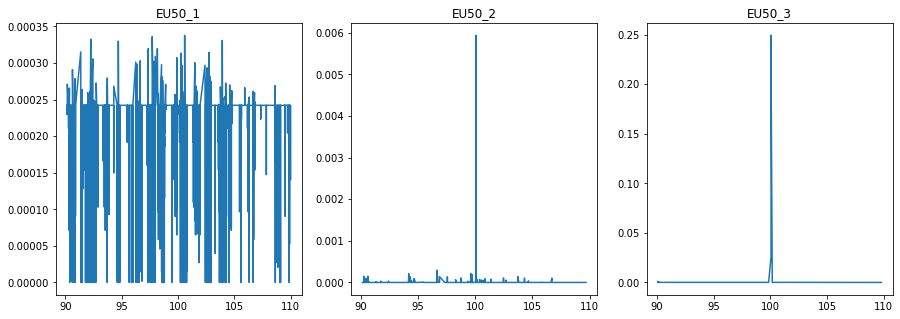

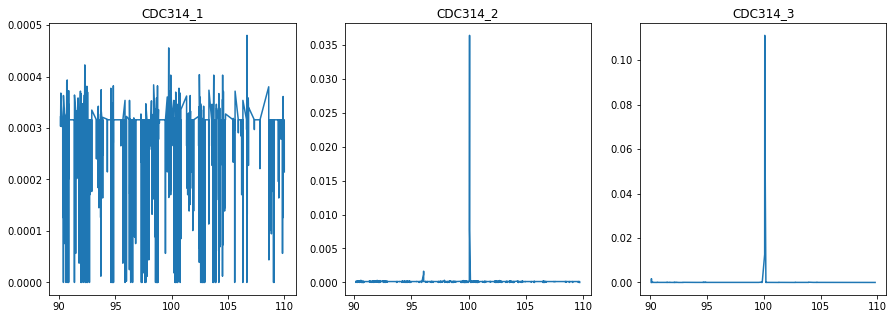

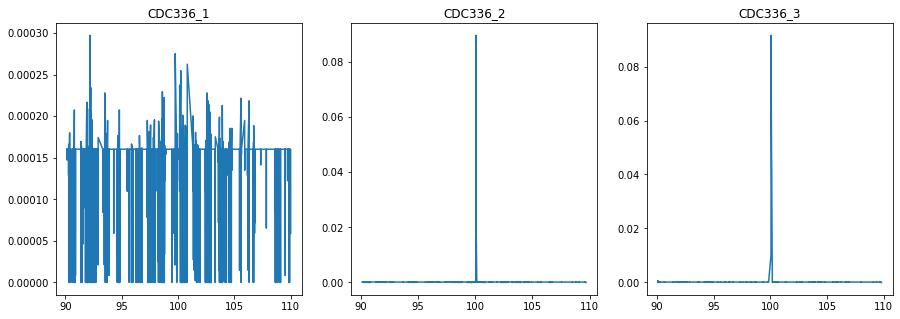

In [81]:
for key in b_samples:
    if(key not in ['TSA']):
        plot_three(dataset_orig, key, val =  'blank_corrected', x = 'mz_interp', blank = ['TSA'], r = [90,110])

for  key in f_samples:
    
    if(key not in ['SBD']):
        plot_three(dataset_orig, key, val =  'blank_corrected', x = 'mz_interp', blank = ['SBD'], r = [90,110])

### Normalization

In [12]:
def normalize(x):
    
    xx = (x - x.mean())/(np.max(x) - np.min(x))
    xx[xx < 0] = 0
    return xx

### Smoothing and thresholding

In [13]:
## Peak Detection following the pseudo code from https://stackoverflow.com/a/22640362/6029703
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))


In [14]:
for keyy in b_samples:
    
    #if(keyy == 'TSA'):
    #    continue;
    
    for i in range(1,4):
        key = keyy + '_' + str(i) 
        data = dataset_orig[key]
        window = 10
        dictionary = thresholding_algo(np.copy(data['normalized']), lag = window, threshold = 0.6, influence = 0.2)
        data['normal_signal'] =dictionary['signals'];
        data['normal_avg'] = dictionary['avgFilter']
        data['normal_avg'] = normalize(data['normal_avg'])
        data['normal_std'] = dictionary['stdFilter'] 
        data['normal_std'] = normalize(data['normal_std'])

for keyy in f_samples:
    
    #if(keyy == 'SBD'):
    #    continue;
    
    for i in range(1,4):
        key = keyy + '_' + str(i) 
        data = dataset_orig[key]
        window = 10
        dictionary = thresholding_algo(np.copy(data['normalized']), lag = window, threshold = 0.6, influence = 0.2)
        data['normal_signal'] =dictionary['signals'];
        data['normal_avg'] = dictionary['avgFilter']
        data['normal_avg'] = normalize(data['normal_avg'])
        data['normal_std'] = dictionary['stdFilter'] 
        data['normal_std'] = normalize(data['normal_std'])

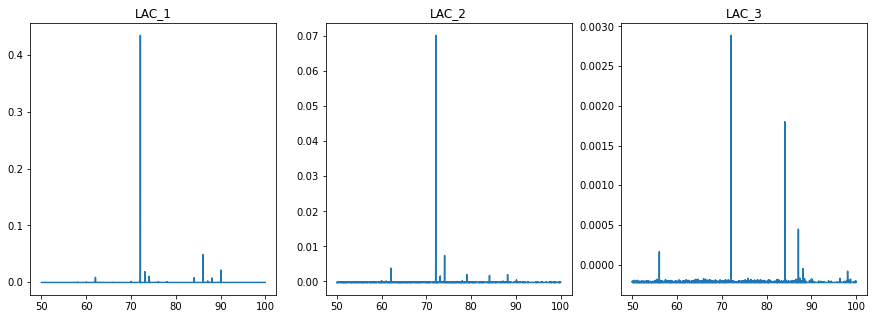

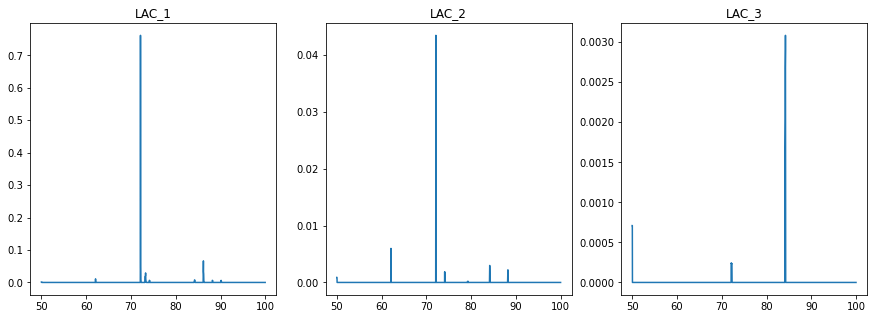

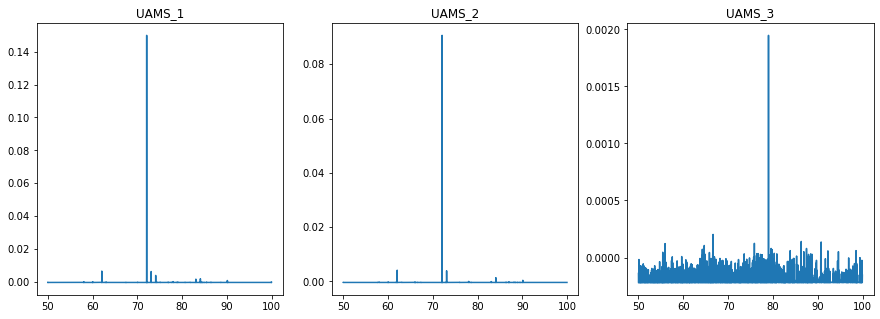

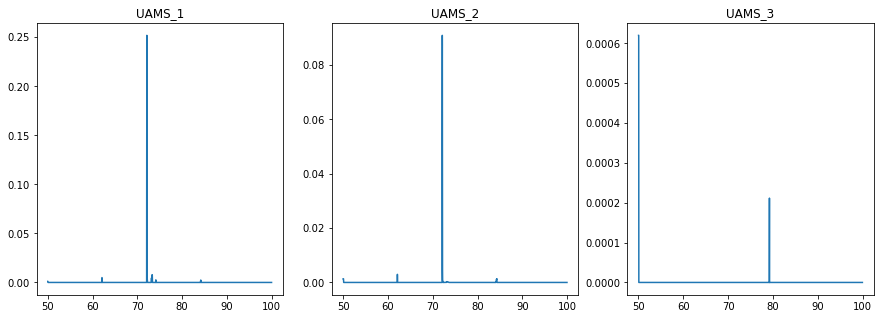

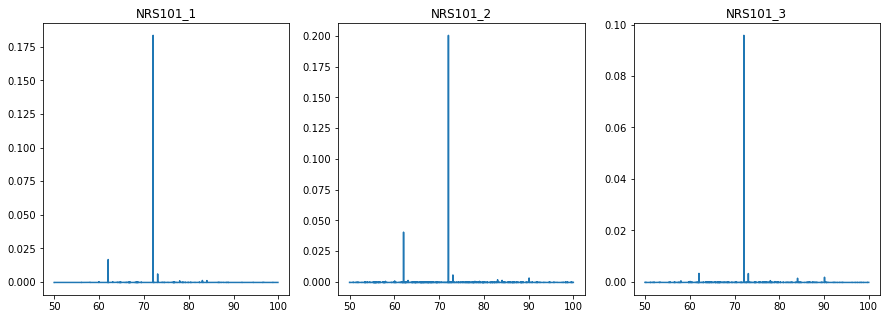

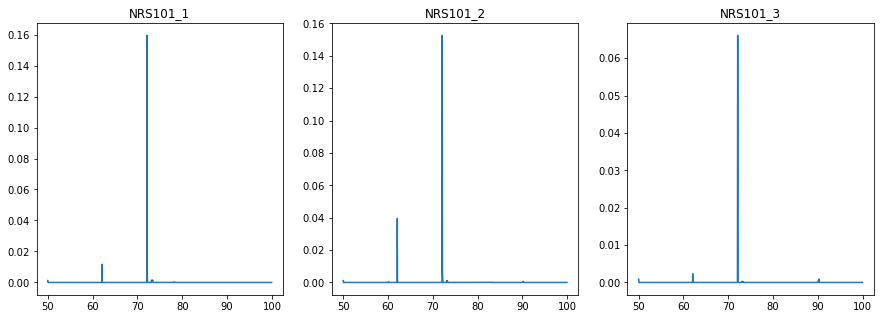

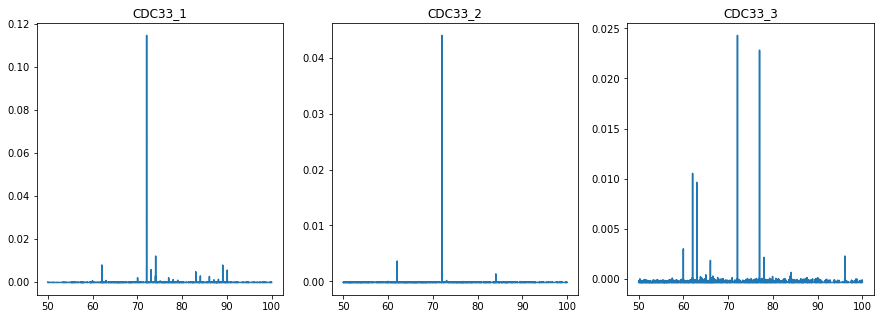

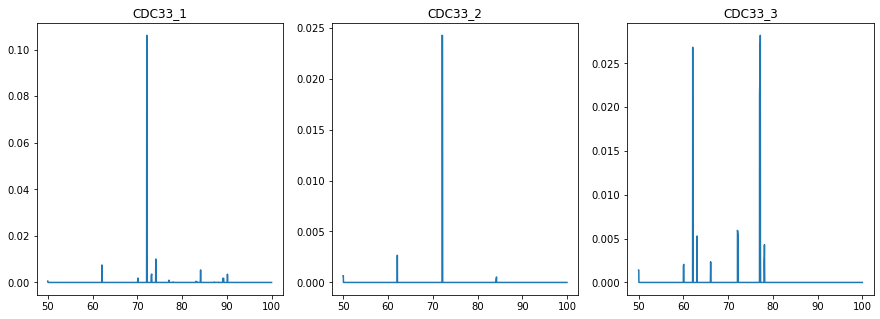

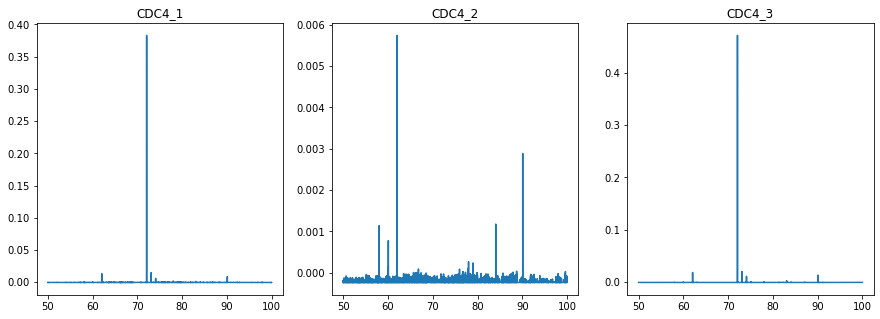

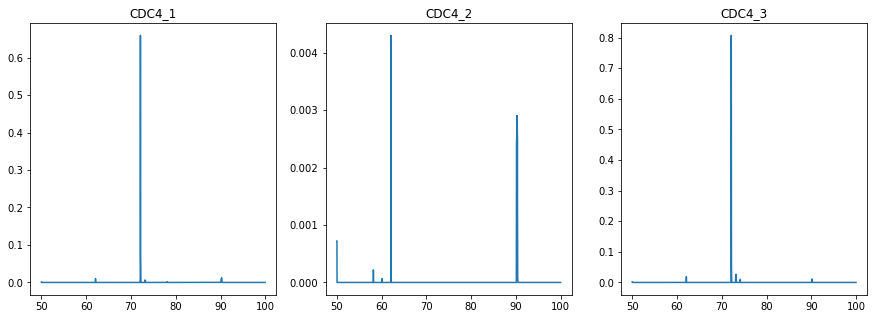

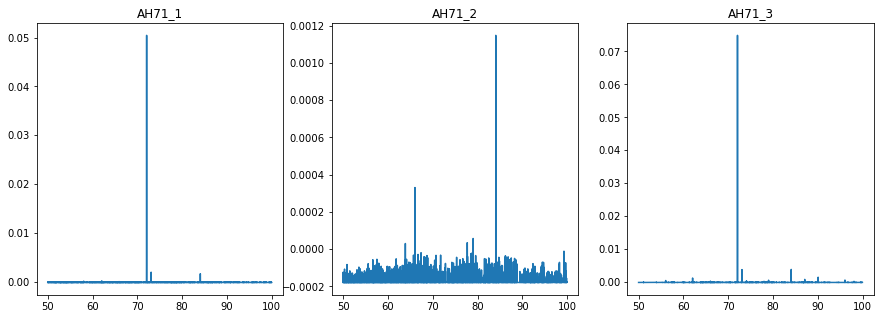

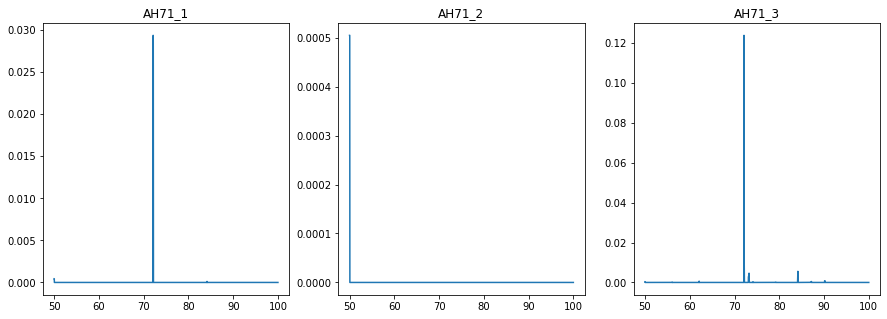

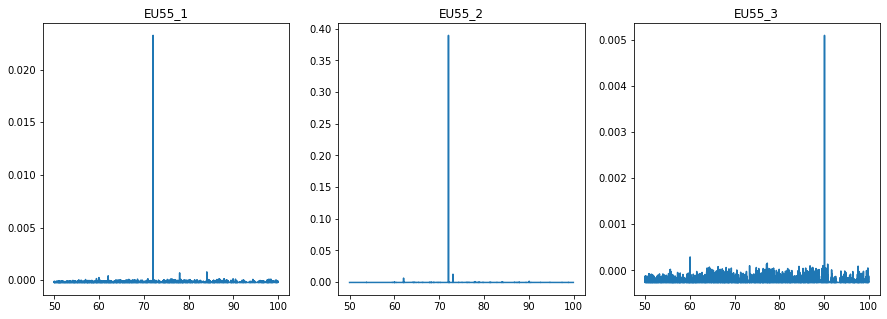

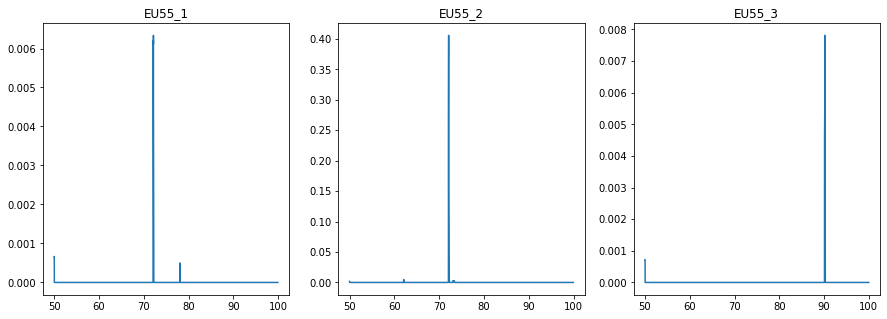

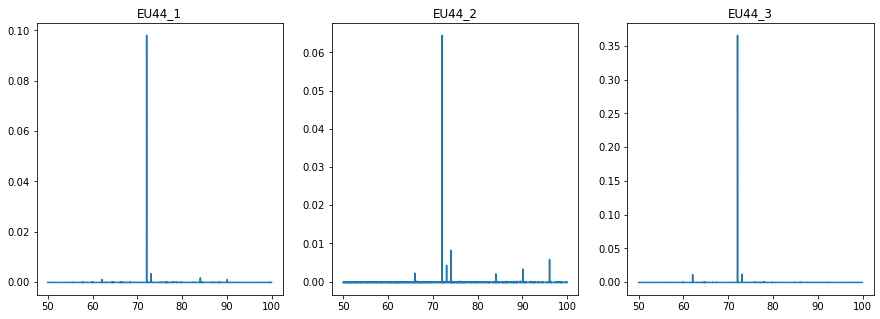

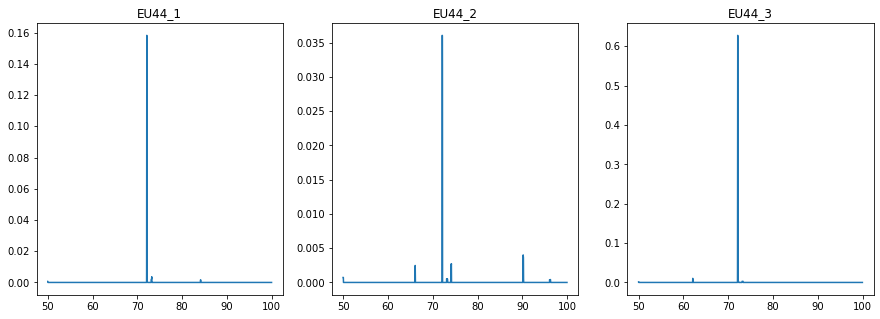

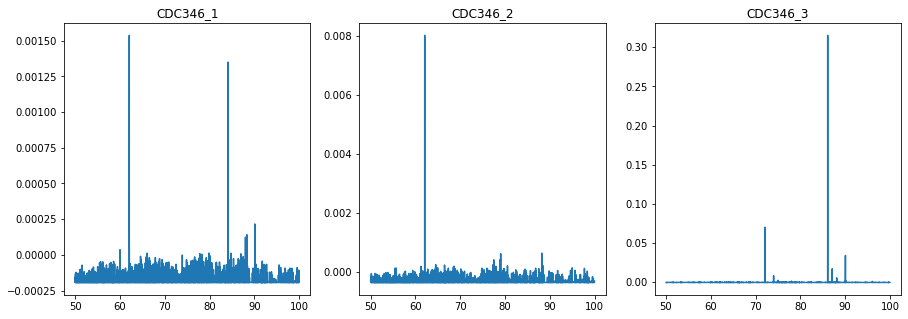

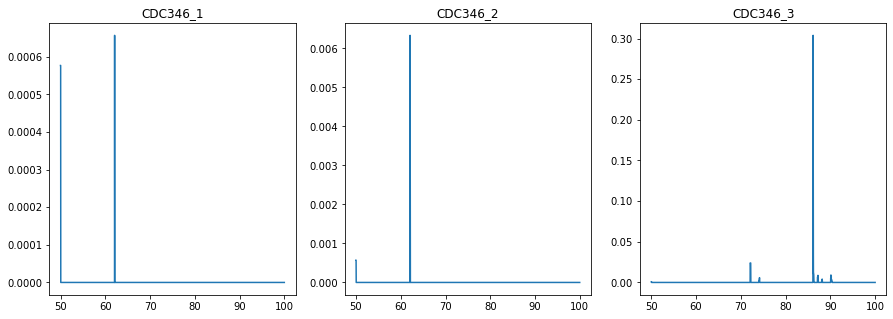

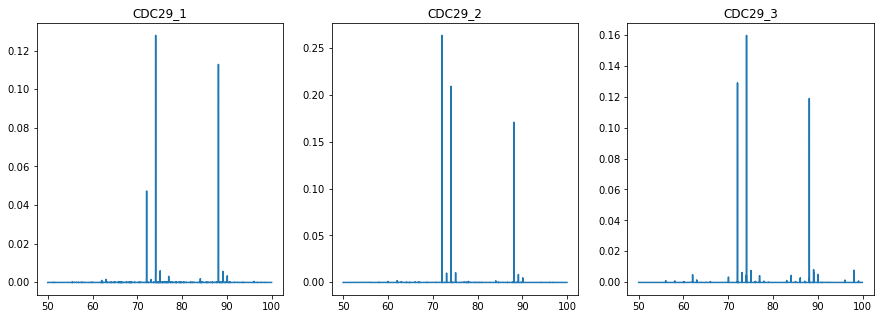

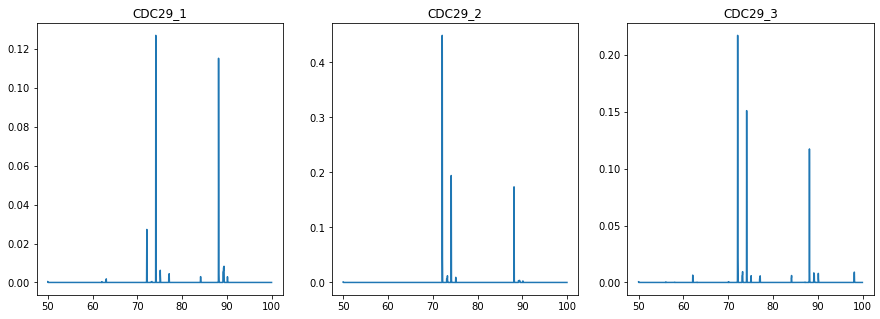

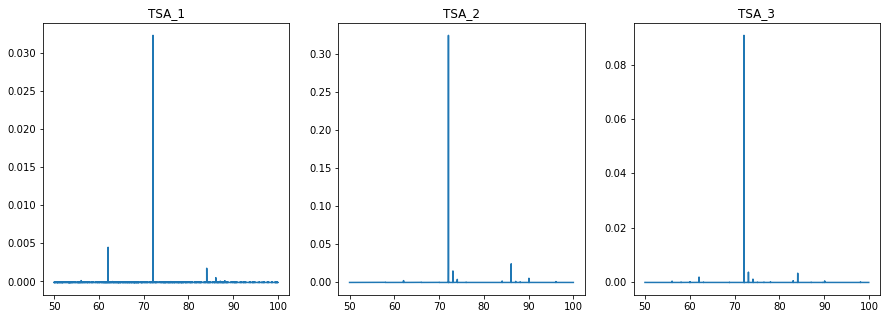

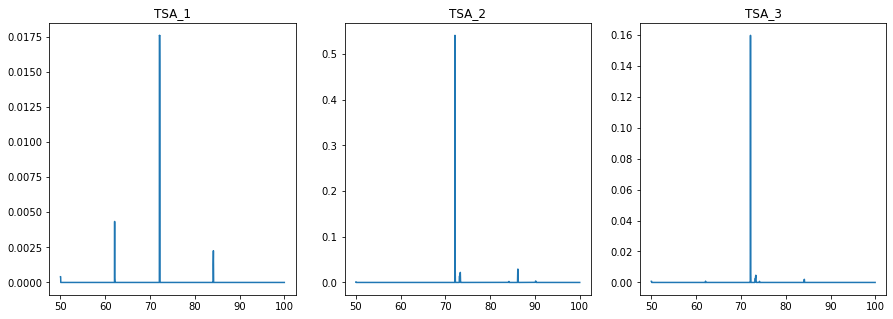

In [15]:
for key in b_samples:
    
    #if(key == 'TSA'):
    #    continue;
    
    plot_three(dataset_orig, key, 'normalized', 'mz', blank = [], r = [50,100])
    plot_three(dataset_orig, key, 'normal_avg', 'mz', blank = [], r = [50,100])

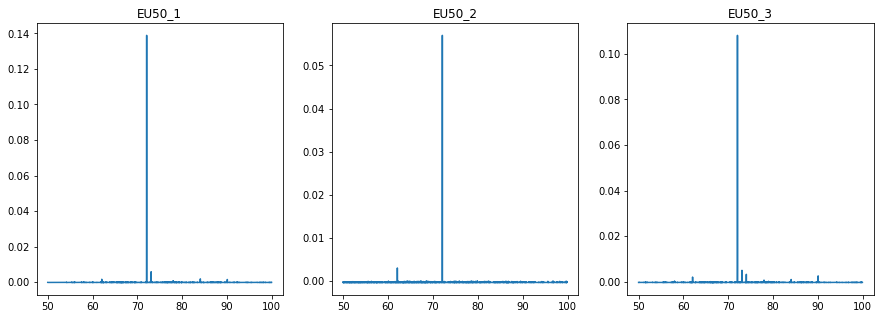

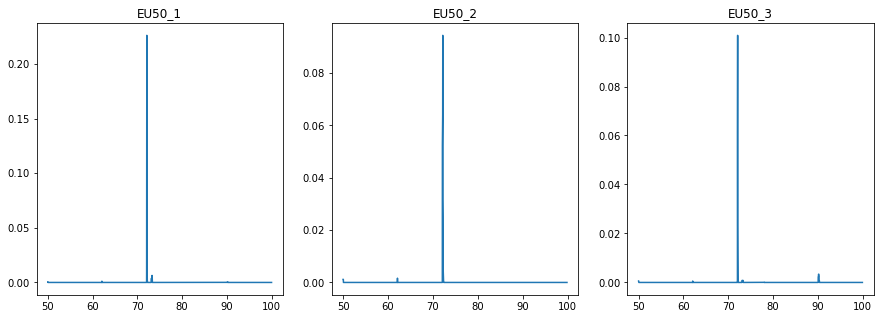

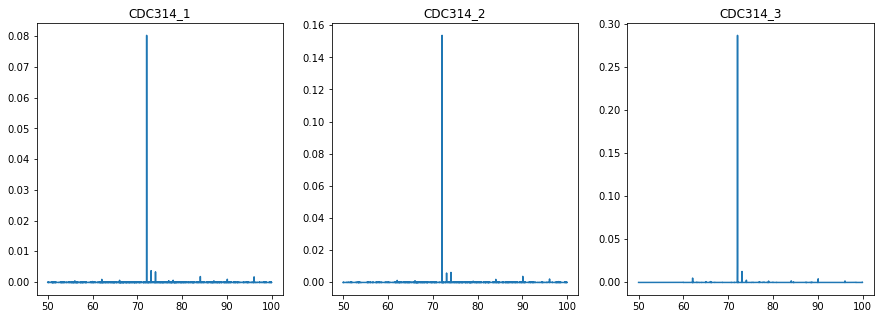

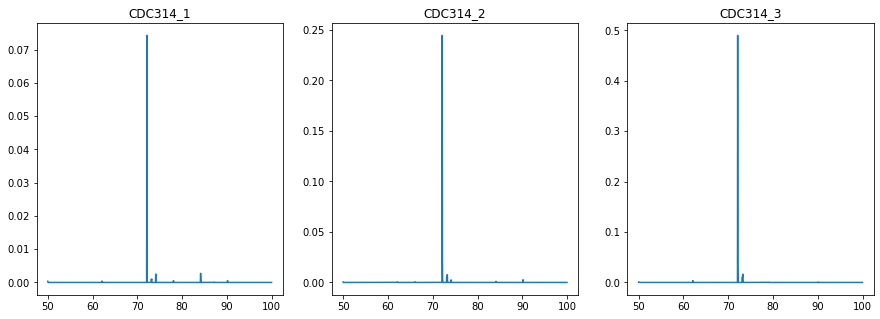

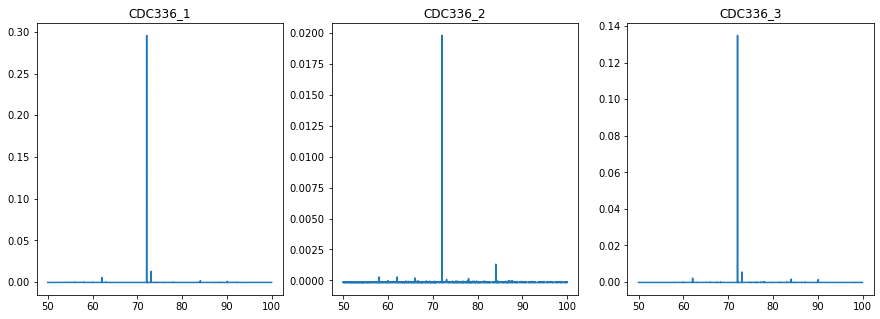

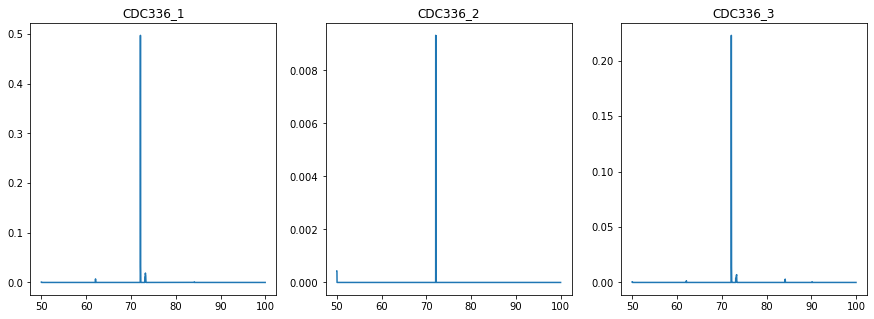

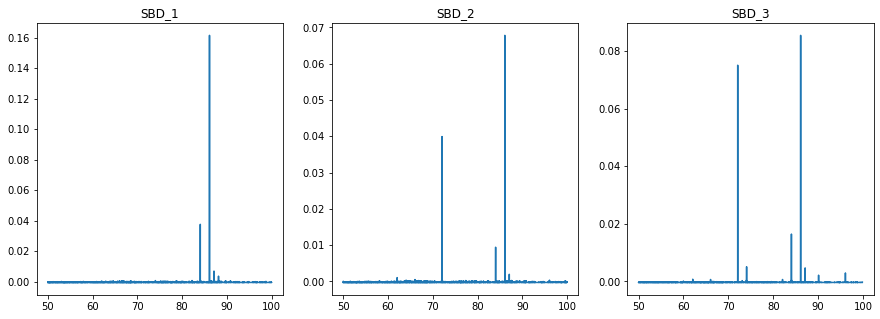

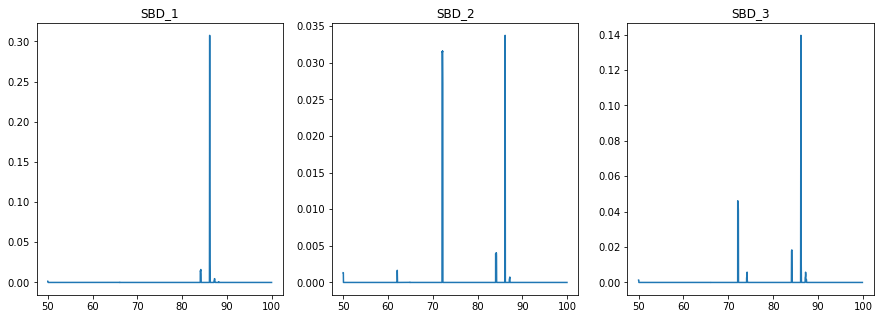

In [16]:
for key in f_samples:
    
    #if(key == 'SBD'):
    #    continue;
    
    plot_three(dataset_orig, key, 'normalized', 'mz', blank = [], r = [50,100])
    plot_three(dataset_orig, key, 'normal_avg', 'mz', blank = [], r = [50,100])

### Peak Detection

In [17]:
def myfind_peaks(x, y, window = False):
    
    thresholds = np.ones(y.shape)
    print(np.mean(y), np.std(y))
    if(window == False):
        window = 700
    else:
        window = window
    
    for i in range(50, 700, window):
        
        start = i
        if(i + window < len(y)):
            end = i + window
        else:
            end = 700
            
        xrange = np.where(np.logical_and(x > start, x < end))[0]
        #print(xrange)
        r1 = xrange[0]
        r2 = xrange[-1]
        
        win = y[r1:r2]
        mean = np.mean(win)
        std = np.std(win)
        sum = np.sum(win)
        great = win[win > 0]
        mode = stats.mode(great)
        #print(mean, std, mode[0])
        #print(mean, std)
        for j in range(r1, r2):
            try:
                thresholds[j] = mean + 1*std #np.mean(y)#mean + 1*std#+ 10*std
            except IndexError:
                print(j, len(thresholds), r1, r2, start, end)
    
    index = np.where(y > thresholds)
    return index, thresholds
    

def plot_peaks(x, y, thresholds, index, thresh = False, r = False ):
    
    if(r):
        r1 = r[0]
        r2 = r[1]
    else:
        r1 = 50
        r2 = 700
    
    xrange = np.where(np.logical_and(x > r1, x < r2))[0]
    r1 = xrange[0]
    r2 = xrange[-1]
    
    if(thresh):
        if(len(index) > 0):

            w = np.where(np.logical_and(index[0] <= r2, index[0] >= r1))
            ind = index[0][w]
            peaks = y[ind]

            plt.figure(figsize = (5,5))
            plt.plot(x[r1:r2], y[r1:r2], 'b',x[r1:r2], thresholds[r1:r2], 'r', x[ind], peaks, 'k*' )
            plt.show()
        else:
            plt.plot(x[r1:r2], y[r1:r2], 'b', x[r1:r2], thresholds[r1:r2], 'r')
    
    else:
        if(len(index) > 0):

            w = np.where(np.logical_and(index[0] <= r2, index[0] >= r1))
            ind = index[0][w]
            peaks = y[ind]

            plt.figure(figsize = (5,5))
            plt.plot(x[r1:r2], y[r1:r2], 'b', x[ind], peaks, 'k*' )
            plt.show()
        else:
            plt.plot(x[r1:r2], y[r1:r2], 'b')


## Blank Correction by removing peaks found in the blank

TSA_1
0.0006371920159272378 0.018600107015417165


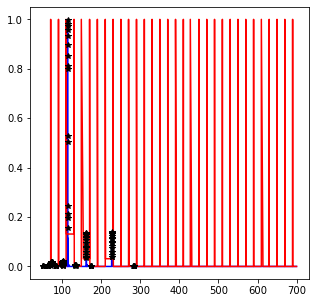

TSA_2
0.001719263345864323 0.027422989112949818


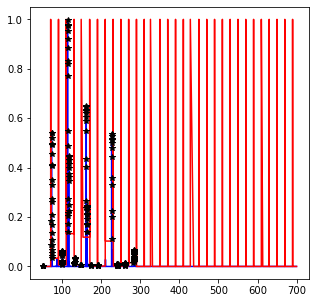

TSA_3
0.0009534426971192818 0.021025060514986774


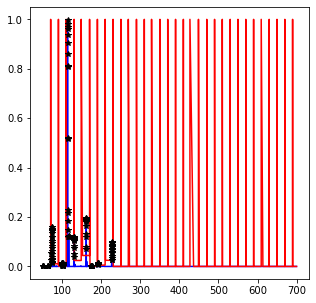

SBD_1
0.0018957283537602819 0.02959157014043795


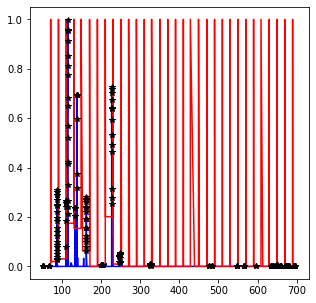

SBD_2
0.0012146279838464013 0.024705634611325574


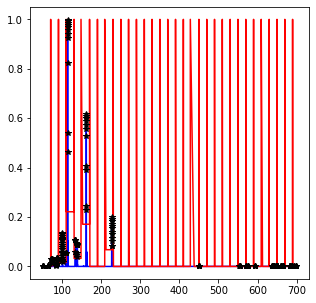

SBD_3
0.0013858352787734368 0.02401635541188108


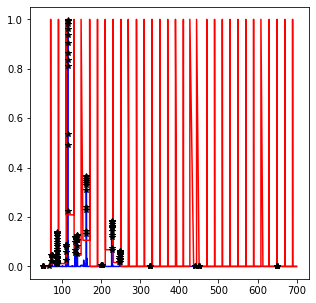

In [18]:
key = 'TSA'

for i in range(1,4):
        
        keyy = key + '_' + str(i)
        print(keyy)
        y = np.copy(dataset_orig[keyy]['normal_avg'])
        x = np.copy(dataset_orig[keyy]['mz'])
        index3, threshold3 = myfind_peaks(x, y, window = 20)
        peak_signal = np.where(dataset_orig[keyy]['normal_signal'] == 1)

        plot_peaks(x,y,threshold3, index = index3, thresh = True)
        dataset_orig[keyy]['peak_ind'] = index3[0]
        
key = 'SBD'

for i in range(1,4):
        
        keyy = key + '_' + str(i)
        print(keyy)
        y = np.copy(dataset_orig[keyy]['normal_avg'])
        x = np.copy(dataset_orig[keyy]['mz'])
        index3, threshold3 = myfind_peaks(x, y, window = 20)
        peak_signal = np.where(dataset_orig[keyy]['normal_signal'] == 1)
        plot_peaks(x,y,threshold3, index = index3, thresh = True)
        dataset_orig[keyy]['peak_ind'] = index3[0]
        

In [19]:

for key in b_samples:
    
    if(key == 'TSA'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        y = np.copy(dataset_orig[keyy]['normal_avg'])
        x = np.copy(dataset_orig[keyy]['mz'])
        xint = np.int32(x)
        
        blank = np.unique(np.int32(dataset_orig['TSA_' + str(i)]['mz'][dataset_orig['TSA_' + str(i)]['peak_ind']]))
        
        for peak in blank:
            
            y[xint == peak] = 0
            
        dataset_orig[keyy]['blank_corrected2'] = y
        
for key in f_samples:
    
    if(key == 'SBD'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        y = np.copy(dataset_orig[keyy]['normal_avg'])
        x = np.copy(dataset_orig[keyy]['mz'])
        xint = np.int32(x)
        
        blank = np.unique(np.int32(dataset_orig['SBD_' + str(i)]['mz'][dataset_orig['SBD_' + str(i)]['peak_ind']]))
        
        for peak in blank:
            
            y[xint == peak] = 0
            
        dataset_orig[keyy]['blank_corrected2'] = y

## Peak Detection for Blank Corrected Data

LAC_1
0.0006718179938761256 0.013024023022209235


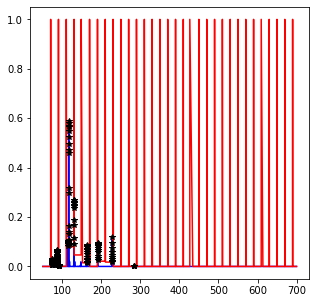

LAC_2
0.00010225159354567692 0.00197136864514379


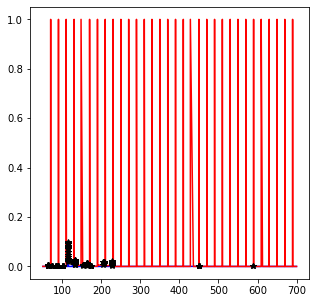

LAC_3
0.00012469640838395723 0.002867185694936966


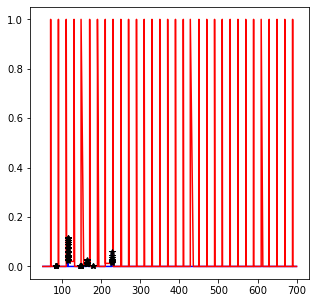

UAMS_1
0.00041870704467308065 0.007403141318415247


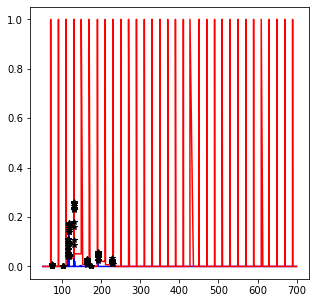

UAMS_2
0.00015935439321098816 0.0030250591180485315


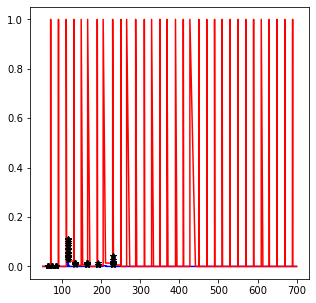

UAMS_3
0.00013915728401524822 0.002585856878017845


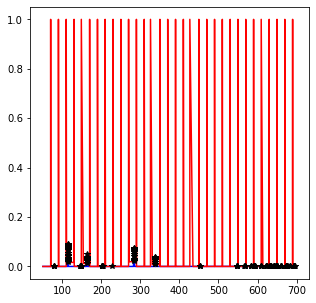

NRS101_1
0.0005064019600541609 0.009933284717150562


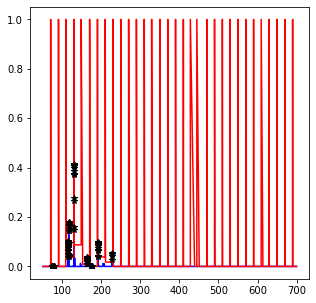

NRS101_2
0.00011469087587878184 0.0022227310838519297


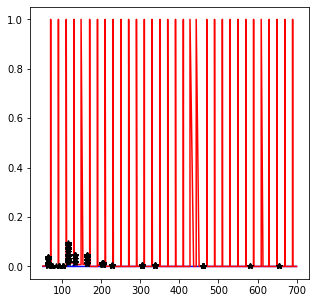

NRS101_3
8.753353566687599e-05 0.0021231561207351794


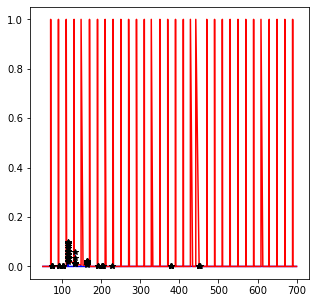

CDC33_1
0.00035442806093362436 0.006870105916266732


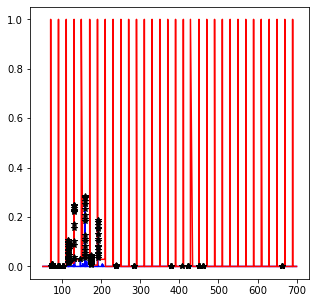

CDC33_2
0.00010022692096384268 0.002299451509824114


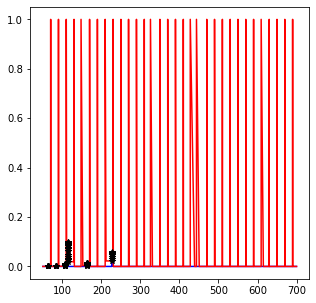

CDC33_3
0.00038247459615463976 0.007569361327260638


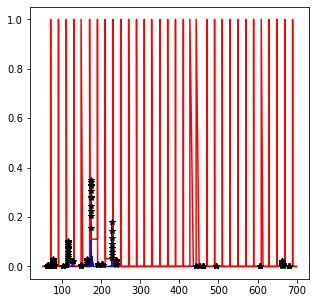

CDC4_1
0.0005705361046100765 0.01196218100851917


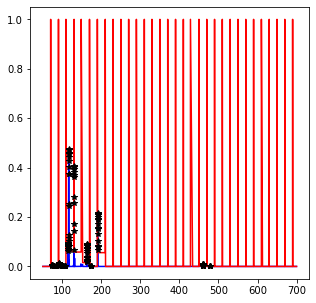

CDC4_2
8.680629830160592e-05 0.0019029389002044525


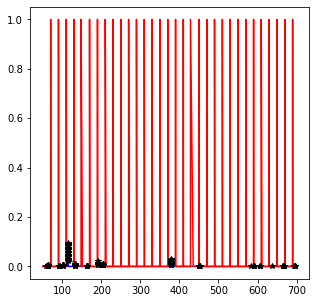

CDC4_3
0.00023462153485688924 0.0032611491466230103


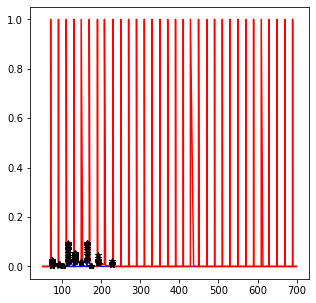

AH71_1
6.15895839069341e-05 0.0018280647529394063


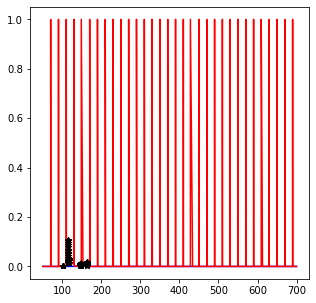

AH71_2
6.666463229919136e-05 0.001964952366726559


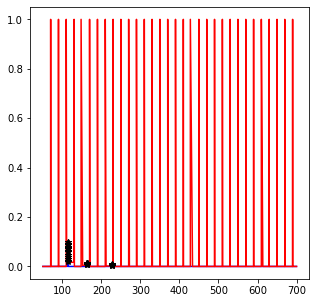

AH71_3
3.257635504308279e-05 0.001037064578916008


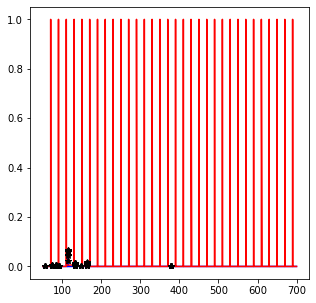

EU55_1
0.0001135478410503006 0.002334849728826369


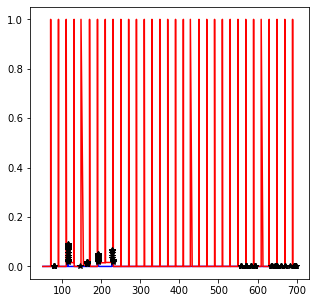

EU55_2
0.00018219716241987976 0.003102200915823442


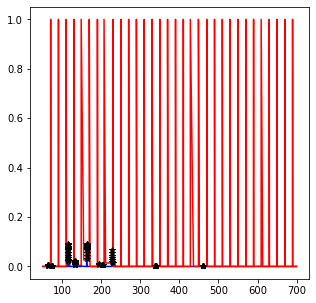

EU55_3
0.00015847220486242314 0.0035999781310196333


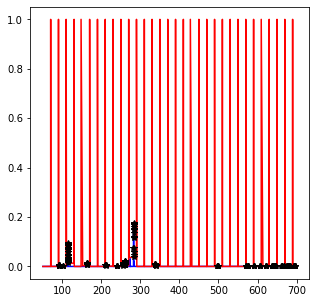

EU44_1
0.00017793773911056916 0.003427664591981768


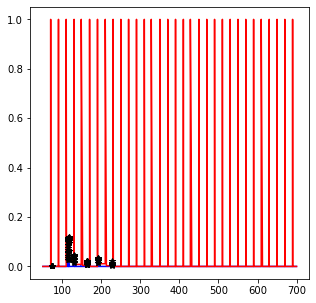

EU44_2
6.925433292531726e-05 0.001848322613171072


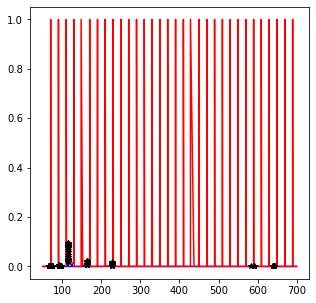

EU44_3
0.00018010710196499435 0.0031818522840743567


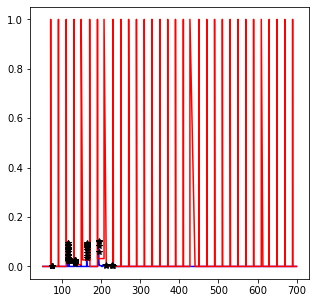

CDC346_1
0.0001403537068122107 0.004057341290867961


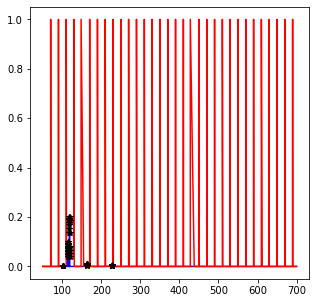

CDC346_2
0.0007704351795340379 0.021968934846771787


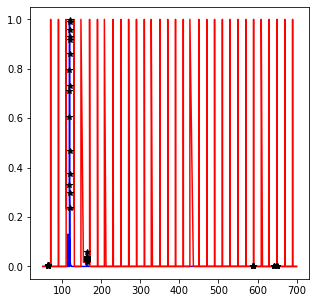

CDC346_3
0.00104788450153512 0.022169338080829718


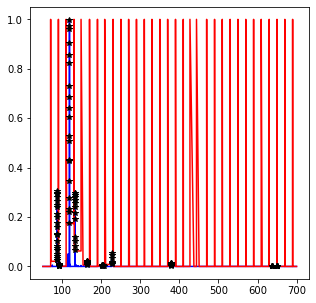

CDC29_1
0.0001641742508365222 0.003295874023019828


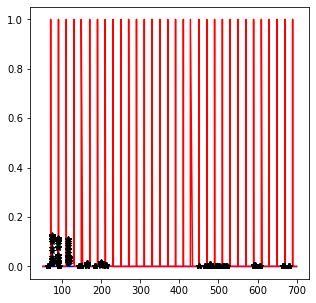

CDC29_2
0.0002835158952497459 0.005126056866599068


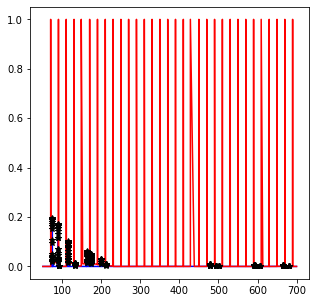

CDC29_3
0.00031105925631324025 0.004561780769154544


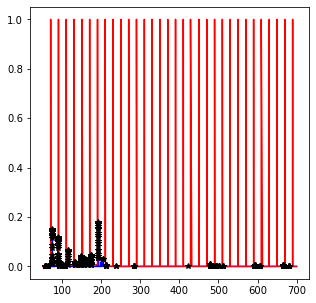

In [20]:
for key in b_samples:
    
    if(key == 'TSA'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        print(keyy)
        y = np.copy(dataset_orig[keyy]['blank_corrected2'])
        x = np.copy(dataset_orig[keyy]['mz'])
        index3, threshold3 = myfind_peaks(x, y, window = 20)
        peak_signal = np.where(dataset_orig[keyy]['normal_signal'] == 1)
        plot_peaks(x,y,threshold3, index = index3, thresh = True)
        dataset_orig[keyy]['peak_ind'] = index3[0]
        

EU50_1
0.00036101395135727695 0.006263875266826886


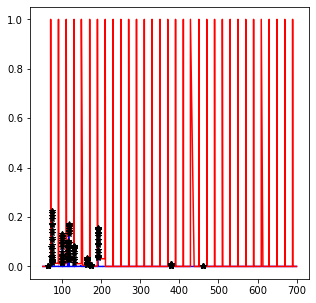

EU50_2
0.00010910755102427876 0.0024380363220653555


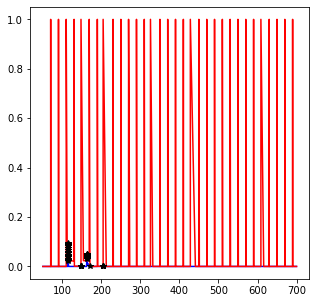

EU50_3
0.00043292984523738917 0.00867200172741801


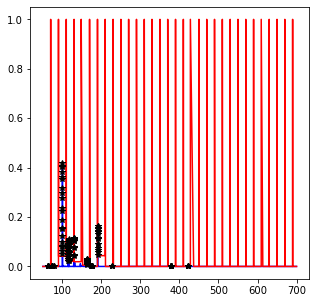

CDC314_1
0.0001326907122825819 0.0025517737899255527


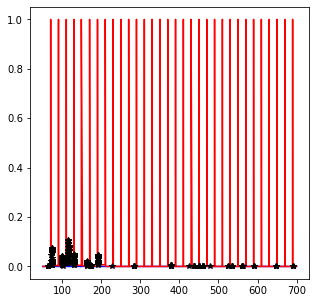

CDC314_2
0.00011538309630381706 0.0031097391286961963


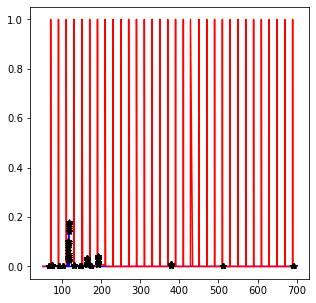

CDC314_3
0.00034969115394712253 0.008228267755718815


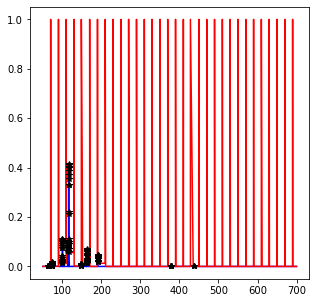

CDC336_1
0.0006191311040993286 0.011997316718238827


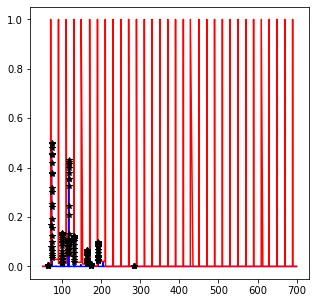

CDC336_2
6.676585879070213e-05 0.0018843255656342166


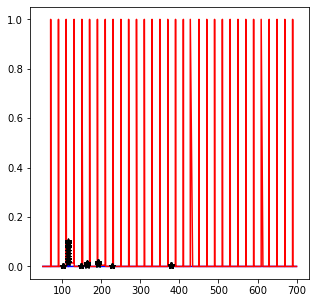

CDC336_3
0.00020336072376646498 0.003931457107060558


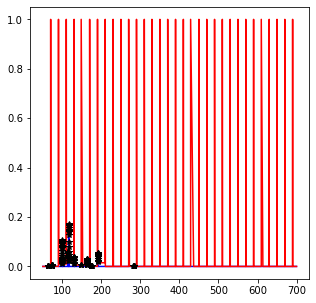

In [21]:
for key in f_samples:
    
    if(key == 'SBD'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        print(keyy)
        y = np.copy(dataset_orig[keyy]['blank_corrected2'])
        x = np.copy(dataset_orig[keyy]['mz'])
        index3, threshold3 = myfind_peaks(x, y, window = 20)
        peak_signal = np.where(dataset_orig[keyy]['normal_signal'] == 1)
        plot_peaks(x,y,threshold3, index = index3, thresh = True)
        dataset_orig[keyy]['peak_ind'] = index3[0]

## Binary feature matrix

In [22]:
Xb = np.zeros((30,650))

yb = np.array([0,0,0,1,1,1,2,2,2,3,3,3,4,4,4,5,5,5,6,6,6,7,7,7,8,8,8,9,9,9])

print(Xb.shape)
k = 0
for key in b_samples:
    
    if(key == 'TSA'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        peak_locs = dataset_orig[keyy]['mz'][dataset_orig[keyy]['peak_ind']]
        peak_vals = dataset_orig[keyy]['blank_corrected2'][dataset_orig[keyy]['peak_ind']]
        
        peak_locs_window = np.int32(peak_locs)
        for j in range(50,700):
            
            try:
                
                location = peak_locs[peak_locs_window == j][0]
            except IndexError:
                location = 0
            Xb[k, j-50] = location
    
        k = k + 1

(30, 650)


In [23]:
Xf = np.zeros((9,650))
yf = np.array([0,0,0,1,1,1,2,2,2])
print(Xf.shape)
k = 0
for key in f_samples:
    
    if(key == 'SBD'):
        continue;
        
    for i in range(1,4):
        
        keyy = key + '_' + str(i)
        peak_locs = dataset_orig[keyy]['mz'][dataset_orig[keyy]['peak_ind']]
        peak_vals = dataset_orig[keyy]['blank_corrected2'][dataset_orig[keyy]['peak_ind']]
        
        peak_locs_window = np.int32(peak_locs)
        
        for j in range(50,700):
            
            try:
                
                location = peak_locs[peak_locs_window == j][0]
            except IndexError:
                location = 0

            Xf[k, j-50] = location
        
        k = k + 1
        
        

(9, 650)


In [24]:
mtype = []

for i in range(0,39):
    if( i < 30):
        mtype.append('bacteria')
    else:
        mtype.append('fungus')
mtype = np.array(mtype)
mtype = mtype.reshape((39,1))
print(mtype.shape)

(39, 1)


## Train-Test Split

In [25]:
Xboth = np.concatenate((Xb[0:30,:], Xf[0:9,:]), axis = 0)
label = np.concatenate((np.zeros((30,1)), np.ones((9,1))), axis = 0)
X_train, X_test, y_train, y_test = model_selection.train_test_split(Xboth, label, train_size=0.70,test_size=0.30, random_state=1)
print ("X_train: ", X_train.shape)
print ("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print ("y_test: ", y_test.shape)


X_train:  (27, 650)
y_train:  (27, 1)
X_test:  (12, 650)
y_test:  (12, 1)


In [26]:
dtrain = pd.DataFrame(X_train)
dtrain['label'] = y_train
dtrain.to_csv('train.csv')

dtest = pd.DataFrame(X_test)
dtest['label'] = y_test
dtest.to_csv('test.csv')

## SMOTE

In [27]:
#sm = SMOTE(random_state = 2, sampling_strategy = 'all')
smote = SMOTE(sampling_strategy= 0.75, random_state=14)
over = RandomOverSampler(sampling_strategy='all', random_state=7)

X_res1, y_res1 = smote.fit_resample(X_train, y_train)
print(X_res1.shape, y_res1.shape)

X_res2, y_res2 = over.fit_resample(X_train, y_train)

over = RandomOverSampler(sampling_strategy='all', random_state=10)
X_res3, y_res3 = over.fit_resample(X_train, y_train)

over = RandomOverSampler(sampling_strategy='all', random_state=77)
X_res4, y_res4 = over.fit_resample(X_train, y_train)

X_res = np.concatenate((X_res1, X_res2, X_res3, X_res4), axis = 0)
y_res = np.concatenate((y_res1, y_res2, y_res3, y_res4), axis = 0)
print(X_res.shape, y_res.shape)
X_up, y_up = X_res, y_res

(36, 650) (36,)
(162, 650) (162,)


In [472]:
smote = SMOTE(sampling_strategy= 'all', random_state=14)
over = RandomOverSampler(sampling_strategy='all', random_state=7)

X_res2, y_res2 = over.fit_resample(X_test, y_test)
X_res1, y_res1 = smote.fit_resample(X_res2, y_res2)
print(X_res1.shape, y_res1.shape)



smote = SMOTE(sampling_strategy='all', random_state=10)
X_res3, y_res3 = smote.fit_resample(X_res2, y_res2)

smote = SMOTE(sampling_strategy='all', random_state=77)
X_res4, y_res4 = smote.fit_resample(X_res2, y_res2)


X_res = np.concatenate((X_res2, X_res3, X_res4), axis = 0)
y_res = np.concatenate(( y_res2, y_res3, y_res4), axis = 0)
print(X_res.shape, y_res.shape)
X_test, y_test = X_res, y_res

(18, 650) (18,)
(54, 650) (54,)


In [28]:
dsmote = pd.DataFrame(X_up)
dsmote['label'] = y_up
dsmote.to_csv('smote.csv')

## PCA

In [29]:
mtype = []

for i in range(len(y_up)):
    if( y_up[i] == 0):
        mtype.append('bacteria')
    else:
        mtype.append('fungus')
mtype = np.array(mtype)
mtype = mtype.reshape((len(y_up),1))
print(mtype.shape)

(162, 1)


In [30]:
X_train[X_train > 0] = 1
X_test[X_test > 0] = 1

pca = PCA().fit(X_train)
pca_features = pca.transform(X_train)
print(pca_features.shape)
print("Variance:{}".format(pca.explained_variance_[0:10]))
print("Perc Variance:{}".format(pca.explained_variance_ratio_[0:10]))

pca_features_test = pca.transform(X_test)
print(pca_features_test.shape)
print("Variance:{}".format(pca.explained_variance_[0:10]))
print("Perc Variance:{}".format(pca.explained_variance_ratio_[0:10]))

(27, 27)
Variance:[1.97203807 1.57324467 1.15565869 0.99916293 0.91382992 0.79920434
 0.71944807 0.67804549 0.60653844 0.51589579]
Perc Variance:[0.15226251 0.12147138 0.08922926 0.0771461  0.07055748 0.06170715
 0.05554911 0.05235239 0.04683128 0.03983269]
(12, 27)
Variance:[1.97203807 1.57324467 1.15565869 0.99916293 0.91382992 0.79920434
 0.71944807 0.67804549 0.60653844 0.51589579]
Perc Variance:[0.15226251 0.12147138 0.08922926 0.0771461  0.07055748 0.06170715
 0.05554911 0.05235239 0.04683128 0.03983269]


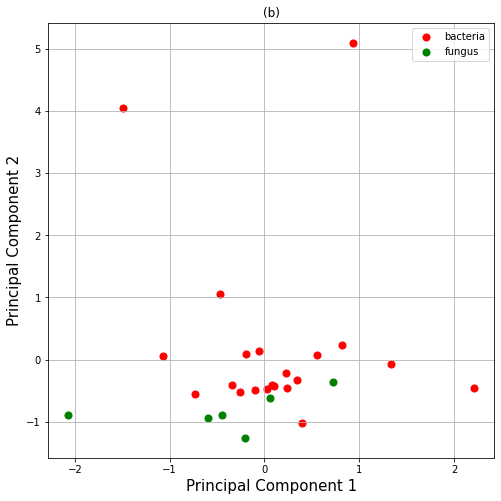

In [31]:
mtype_df = pd.DataFrame(data = mtype, columns = ['Type'])
mtype_df.head()

principalDf = pd.DataFrame(data = np.concatenate((pca_features[:,6:7], pca_features[:,0:1]),axis = 1)
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, mtype_df], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = plt.axes()
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 1', fontsize = 15)


targets = ['bacteria', 'fungus']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.set_title('(b)')
#ax.set_xlim([-1000,1000])
#ax.set_ylim([-500,500])
ax.grid()

In [32]:
X_up[X_up > 0] = 1
X_test[X_test > 0] = 1

pca = PCA().fit(X_up)
pca_features = pca.transform(X_up)
print(pca_features.shape)
print("Variance:{}".format(pca.explained_variance_[0:10]))
print("Perc Variance:{}".format(pca.explained_variance_ratio_[0:10]))

pca_features_test = pca.transform(X_test)
print(pca_features_test.shape)
print("Variance:{}".format(pca.explained_variance_[0:10]))
print("Perc Variance:{}".format(pca.explained_variance_ratio_[0:10]))

(162, 162)
Variance:[1.77071099 1.15274096 1.09656707 0.87376812 0.72250672 0.6855729
 0.54626094 0.53606241 0.50630719 0.44269856]
Perc Variance:[0.16040011 0.10442121 0.09933269 0.07915041 0.06544838 0.06210272
 0.04948313 0.04855929 0.04586391 0.04010191]
(12, 162)
Variance:[1.77071099 1.15274096 1.09656707 0.87376812 0.72250672 0.6855729
 0.54626094 0.53606241 0.50630719 0.44269856]
Perc Variance:[0.16040011 0.10442121 0.09933269 0.07915041 0.06544838 0.06210272
 0.04948313 0.04855929 0.04586391 0.04010191]


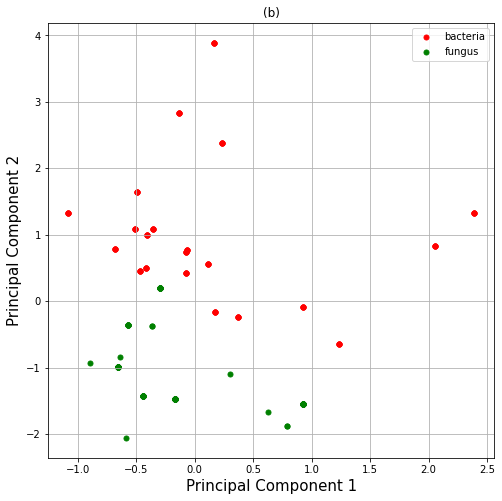

In [33]:
mtype_df = pd.DataFrame(data = mtype, columns = ['Type'])
mtype_df.head()

principalDf = pd.DataFrame(data = np.concatenate((pca_features[:,6:7], pca_features[:,0:1]),axis = 1)
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, mtype_df], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = plt.axes()
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_xlabel('Principal Component 1', fontsize = 15)


targets = ['bacteria', 'fungus']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Type'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 25)
ax.legend(targets)
ax.set_title('(b)')
#ax.set_xlim([-1000,1000])
#ax.set_ylim([-500,500])
ax.grid()

In [34]:
from sklearn import tree
from sklearn import ensemble

inp = pca_features
clf = tree.DecisionTreeClassifier() #ensemble.RandomForestClassifier() # defining decision tree classifier
clf= clf.fit(X_up, y_up) # train data on new data and new target
prediction = clf.predict(X_test) 
text_representation = tree.export_text(clf)
print(text_representation)
print(y_test, prediction)
print(clf.score(X_test, y_test))

|--- feature_50 <= 0.50
|   |--- feature_327 <= 0.50
|   |   |--- class: 0.0
|   |--- feature_327 >  0.50
|   |   |--- feature_97 <= 0.50
|   |   |   |--- class: 0.0
|   |   |--- feature_97 >  0.50
|   |   |   |--- class: 1.0
|--- feature_50 >  0.50
|   |--- class: 1.0

[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]] [0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
0.8333333333333334


In [35]:
dsmote = pd.read_csv('smote.csv')
dsmote.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,641,642,643,644,645,646,647,648,649,label
0,0,0.0,0.0,0.0,0.0,0.0,0.0,56.075,0.0,58.093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:

feature50 = dsmote['50'].loc[dsmote['50'] > 0].values
feature327 = dsmote['327'].loc[dsmote['327'] > 0].values
feature97 =dsmote['97'].loc[dsmote['97'] > 0].values

peak_at_50 = max(feature50,key= list(feature50).count)
peak_at_327 = max(feature327,key= list(feature327).count)
peak_at_97 = max(feature97,key= list(feature97).count)

In [37]:
print(peak_at_50, peak_at_327, peak_at_97)

100.0758 377.2343 147.1513


## Kmeans Clustering 

[[0.        2.3937827]
 [2.3937827 0.       ]]


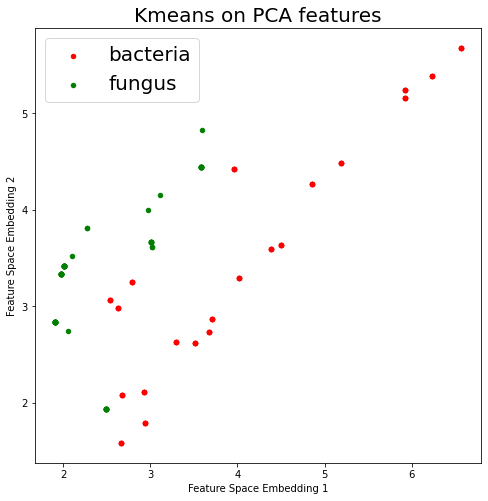

In [38]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_features)
kpredict = kmeans.labels_
pca_features_transformed = kmeans.transform(pca_features)
cc = kmeans.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize = (8,8))
ax = plt.axes()

for i in range(len(y_up)):
    
    if(y_up[i]):

        ax.scatter(pca_features_transformed[i,1], pca_features_transformed[i,0], color = 'g', s= 20)
    
    else:
        ax.scatter(pca_features_transformed[i,1], pca_features_transformed[i,0], color = 'r', s = 20)

ax.legend(targets, fontsize = 20)

#ax.tick_params(
#    axis='both',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False,
#    labelleft = False, 
#    left = False) # labels along the bottom edge are off
ax.set_title('Kmeans on PCA features', fontsize = 20)
ax.set_xlabel('Feature Space Embedding 1')
ax.set_ylabel('Feature Space Embedding 2')
fig.show()
fig.savefig('kmeans_bfm.png')
print(cc)

[[0.        2.3937827]
 [2.3937827 0.       ]]


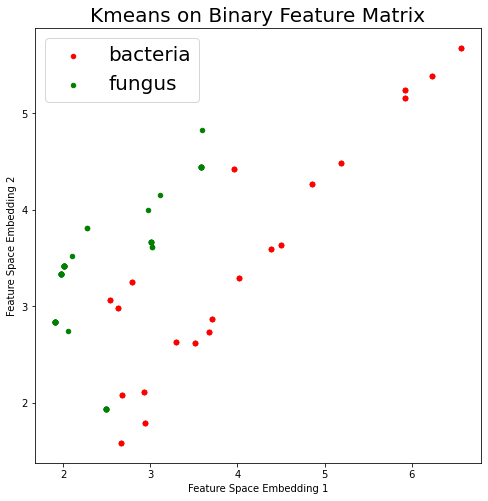

In [39]:

kmeans = KMeans(n_clusters=2, random_state=0).fit(X_up)
kpredict = kmeans.labels_
pca_features_transformed = kmeans.transform(X_up)
cc = kmeans.transform(kmeans.cluster_centers_)


fig = plt.figure(figsize = (8,8))
ax = plt.axes()

for i in range(len(y_up)):
    
    if(y_up[i]):

        ax.scatter(pca_features_transformed[i,1], pca_features_transformed[i,0], color = 'g', s= 20)
    
    else:
        ax.scatter(pca_features_transformed[i,1], pca_features_transformed[i,0], color = 'r', s = 20)

ax.legend(targets, fontsize = 20)

#ax.tick_params(
#    axis='both',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False,
#    labelleft = False, 
#    left = False) # labels along the bottom edge are off
ax.set_title('Kmeans on Binary Feature Matrix', fontsize = 20)
ax.set_xlabel('Feature Space Embedding 1')
ax.set_ylabel('Feature Space Embedding 2')
fig.show()
fig.savefig('kmeans_bfm.png')
print(cc)

## Learning 

In [40]:
from train_functionsss import svm, knn, logisticRegression, lasso, randomForest, get_metrics

In [ ]:
Xboth = np.concatenate((Xb[0:30,:], Xf[0:9,:]), axis = 0)
label = np.concatenate((np.zeros((30,1)), np.ones((9,1))), axis = 0)
kfold = 3

kf = model_selection.KFold(n_splits = kfold, shuffle = True, random_state = 45)
svm_models = []
svm_results = []

knn_models = []
knn_results = []

rv_models = []
rv_results = []

lasso_models = []
lasso_results = []

logistic_models = []
logistic_results = []

for train_index, val_index in kf.split(Xboth):
    
    X_train, X_test = Xboth[train_index], Xboth[val_index]
    y_train, y_test = label[train_index], label[val_index]

    try:
        smote = SMOTE(sampling_strategy= 0.75, random_state=14)
        over = RandomOverSampler(sampling_strategy='all', random_state=7)

        X_res1, y_res1 = smote.fit_resample(X_train, y_train)
        print(X_res1.shape, y_res1.shape)

        X_res2, y_res2 = over.fit_resample(X_train, y_train)

        over = RandomOverSampler(sampling_strategy='all', random_state=10)
        X_res3, y_res3 = over.fit_resample(X_train, y_train)

        over = RandomOverSampler(sampling_strategy='all', random_state=77)
        X_res4, y_res4 = over.fit_resample(X_train, y_train)

        X_res = np.concatenate((X_res1, X_res2, X_res3, X_res4), axis = 0)
        y_res = np.concatenate((y_res1, y_res2, y_res3, y_res4), axis = 0)
        X_up, y_up = X_res, y_res
        
    except ValueError:
        
        smote = SMOTE(sampling_strategy= 'all', random_state=14, k_neighbors = 5)
        over1 = RandomOverSampler(sampling_strategy='minority', random_state=7)
        
        X_train, y_train = over.fit_resample(X_train, y_train)
        
        X_res1, y_res1 = smote.fit_resample(X_train, y_train)
        print(X_res1.shape, y_res1.shape)
        over = RandomOverSampler(sampling_strategy='all', random_state=90)
        X_res2, y_res2 = over.fit_resample(X_train, y_train)

        over = RandomOverSampler(sampling_strategy='all', random_state=10)
        X_res3, y_res3 = over.fit_resample(X_train, y_train)

        over = RandomOverSampler(sampling_strategy='all', random_state=77)
        X_res4, y_res4 = over.fit_resample(X_train, y_train)

        X_res = np.concatenate((X_res1, X_res2, X_res3, X_res4), axis = 0)
        y_res = np.concatenate((y_res1, y_res2, y_res3, y_res4), axis = 0)
        X_up, y_up = X_res, y_res
        
    
    
    print ("X_train: ", X_up.shape)
    print ("y_train: ", y_up.shape)
    print("X_test: ", X_test.shape)
    print ("y_test: ", y_test.shape)
    
    svm_model = svm(X_up, y_up)
    knn_model = knn(X_up, y_up)
    rv_model = randomForest(X_up, y_up)
    lasso_model = lasso(X_up, y_up)
    logistic_model = logisticRegression(X_up, y_up)

    result_svm = get_metrics(X_test, y_test, svm_model)
    result_knn = get_metrics(X_test, y_test, knn_model)
    result_rv = get_metrics(X_test, y_test, rv_model)
    result_lasso = get_metrics(X_test, y_test, lasso_model)
    result_logistic = get_metrics(X_test, y_test, logistic_model)
    
    svm_models.append(svm_model)
    svm_results.append(result_svm)
    
    knn_models.append(knn_model)
    knn_results.append(result_knn)
    
    rv_models.append(rv_model)
    rv_results.append(result_rv)
    
    lasso_models.append(lasso_model)
    lasso_results.append(result_lasso)
    
    logistic_models.append(logistic_model)
    logistic_results.append(result_logistic)
    

(33, 650) (33,)
X_train:  (147, 650)
y_train:  (147,)
X_test:  (13, 650)
y_test:  (13, 1)


In [ ]:


tpr_svm = []
fpr_svm = []
prc_svm = []
rec_svm = []

tpr_knn = []
fpr_knn = []
prc_knn = []
rec_knn = []

tpr_lasso = []
fpr_lasso = []
prc_lasso = []
rec_lasso = []


tpr_logistic = []
fpr_logistic = []
prc_logistic = []
rec_logistic = []


tpr_rv = []
fpr_rv = []
prc_rv = []
rec_rv = []



for i in range(3):
    
    tpr_svm.append(svm_results[i]['tpr_roc'])
    tpr_knn.append(knn_results[i]['tpr_roc'])
    tpr_lasso.append(lasso_results[i]['tpr_roc'])
    tpr_logistic.append(logistic_results[i]['tpr_roc'])
    tpr_rv.append(rv_results[i]['tpr_roc'])
    
    fpr_svm.append(svm_results[i]['fpr_roc'])
    fpr_knn.append(knn_results[i]['fpr_roc'])
    fpr_lasso.append(lasso_results[i]['fpr_roc'])
    fpr_logistic.append(logistic_results[i]['fpr_roc'])
    fpr_rv.append(rv_results[i]['fpr_roc'])
    
    prc_svm.append(svm_results[i]['precision_prc'])
    prc_knn.append(knn_results[i]['precision_prc'])
    prc_lasso.append(lasso_results[i]['precision_prc'])
    prc_logistic.append(logistic_results[i]['precision_prc'])
    prc_rv.append(rv_results[i]['precision_prc'])
    
    rec_svm.append(svm_results[i]['recall_prc'])
    rec_knn.append(knn_results[i]['recall_prc'])
    rec_lasso.append(lasso_results[i]['recall_prc'])
    rec_logistic.append(logistic_results[i]['recall_prc'])
    rec_rv.append(rv_results[i]['recall_prc'])
    
    
    

In [ ]:
auc_svm = []
sen_svm = []
spc_svm = []
ppv_svm = []
acc_svm = []
npv_svm = []

auc_knn = []
sen_knn = []
spc_knn = []
ppv_knn = []
acc_knn = []
npv_knn = []

auc_logistic = []
sen_logistic = []
spc_logistic = []
ppv_logistic = []
acc_logistic = []
npv_logistic = []

auc_lasso = []
sen_lasso = []
spc_lasso = []
ppv_lasso = []
acc_lasso = []
npv_lasso = []

auc_rv = []
sen_rv = []
spc_rv = []
ppv_rv = []
acc_rv = []
npv_rv = []

for i in range(3):
    
    auc_svm.append(svm_results[i]['auroc'])
    auc_knn.append(knn_results[i]['auroc'])
    auc_lasso.append(lasso_results[i]['auroc'])
    auc_logistic.append(logistic_results[i]['auroc'])
    auc_rv.append(rv_results[i]['auroc'])
    
    sen_svm.append(svm_results[i]['sensitivity'])
    sen_knn.append(knn_results[i]['sensitivity'])
    sen_lasso.append(lasso_results[i]['sensitivity'])
    sen_logistic.append(logistic_results[i]['sensitivity'])
    sen_rv.append(rv_results[i]['sensitivity'])
    
    spc_svm.append(svm_results[i]['specificity'])
    spc_knn.append(knn_results[i]['specificity'])
    spc_lasso.append(lasso_results[i]['specificity'])
    spc_logistic.append(logistic_results[i]['specificity'])
    spc_rv.append(rv_results[i]['specificity'])
    
    ppv_svm.append(svm_results[i]['precision'])
    ppv_knn.append(knn_results[i]['precision'])
    ppv_lasso.append(lasso_results[i]['precision'])
    ppv_logistic.append(logistic_results[i]['precision'])
    ppv_rv.append(rv_results[i]['precision'])
    
    npv_svm.append(svm_results[i]['npv'])
    npv_knn.append(knn_results[i]['npv'])
    npv_lasso.append(lasso_results[i]['npv'])
    npv_logistic.append(logistic_results[i]['npv'])
    npv_rv.append(rv_results[i]['npv'])
    
    acc_svm.append(svm_results[i]['accuracy'])
    acc_knn.append(knn_results[i]['accuracy'])
    acc_lasso.append(lasso_results[i]['accuracy'])
    acc_logistic.append(logistic_results[i]['accuracy'])
    acc_rv.append(rv_results[i]['accuracy'])
    
    
    
    
    

In [ ]:
results = {
            'Name': ['Logistic Regression', 'Logistic Regression with Lasso', 'KNN', 'SVM', 'Random Forest'],
            'accuracy': [np.mean(acc_logistic) , np.mean(acc_lasso), np.mean(acc_knn), np.mean(acc_svm), np.mean(acc_rv)],
            'ppv': [np.mean(ppv_logistic) , np.mean(ppv_lasso), np.mean(ppv_knn), np.mean(ppv_svm), np.mean(ppv_rv)],
            'npv': [np.mean(npv_logistic) , np.mean(npv_lasso), np.mean(npv_knn), np.mean(npv_svm), np.mean(npv_rv)],
            'AUC Score': [np.mean(auc_logistic) , np.mean(auc_lasso), np.mean(auc_knn), np.mean(auc_svm), np.mean(auc_rv)],
            'sensitivity':[np.mean(sen_logistic) , np.mean(sen_lasso), np.mean(sen_knn), np.mean(sen_svm), np.mean(sen_rv)],
            'specificity' : [np.mean(spc_logistic) , np.mean(spc_lasso), np.mean(spc_knn), np.mean(spc_svm), np.mean(spc_rv)]
          }

df = pd.DataFrame(results)


In [ ]:
df.head(10)

In [577]:
acc_svm

[0.8461538461538461, 0.7692307692307693, 0.6923076923076923]